In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [80]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import os

# Set path to your folder inside Google Drive
data_path = "/content/drive/My Drive/data_psdv"

# List all files in the folder
files = os.listdir(data_path)
print("Files in dataset folder:", files)

Files in dataset folder: ['Data.csv', 'NCAP_Funding.csv', 'State_data.csv', 'Dataset Description.gdoc']


In [82]:
#Loading the datasets
data = pd.read_csv(os.path.join(data_path, "Data.csv"))
State_Data = pd.read_csv(os.path.join(data_path,'State_data.csv'))
NCAP_Funding = pd.read_csv(os.path.join(data_path,'NCAP_Funding.csv'))

#Checking the first few rows of the datasets
print("Data\n")
print(Data.head())
print("\nState Data\n")
print(State_Data.head())
print("\nNCAP Funding\n")
print(NCAP_Funding.head())

Data

    Timestamp                       station  PM2.5       PM10  \
0  2017-01-01    32Bungalows, Bhilai - CECB    NaN        NaN   
1  2017-01-01          AIIMS, Raipur - CECB    NaN        NaN   
2  2017-01-01  Adarsh Nagar, Jaipur - RSPCB    NaN        NaN   
3  2017-01-01    Airoli, Navi Mumbai - MPCB    NaN  54.743723   
4  2017-01-01    Airport Area, Indore - IMC    NaN        NaN   

                                             address         city   latitude  \
0  Bhilai RO Office, 5, 32 Bungalows, Bhilai, Dis...       Bhilai  21.194815   
1  All India Institute Of Medical Science, Gate N...       Raipur  21.258815   
2  Psychiatric Centre, Janta Colony, Govind Marg,...       Jaipur  26.902909   
3                                                NaN  Navi Mumbai  19.149400   
4                                                NaN          NaN        NaN   

   longitude         state  
0  81.314770  Chhattisgarh  
1  81.578979  Chhattisgarh  
2  75.836858     Rajasthan  
3  72.

# Spatial Aggreagations

1) Which state (consider all stations in that state) has the highest average PM2.5 concentration across all stations and across all years?

In [ ]:
grouped_data=data.groupby("state")["PM2.5"].mean()
max_data=grouped_data.idxmax()

print(f"The state with the highest average PM2.5 concentration is '{max_data}' with average value as {round(grouped_data[max_data],2)}")

The state with the highest average PM2.5 concentration is 'Delhi' with average value as 104.1


2) Which state (consider all stations in that state) had the most days with hazardous PM2.5 levels (above 300 µg/m³) for the year 2023?

In [ ]:
data["Timestamp"]=pd.to_datetime(data["Timestamp"],errors="coerce")

data_2023=data[data["Timestamp"].dt.year==2023]

data_2023=data_2023.dropna(subset=["PM2.5"])

hazardous_PM25=data_2023[data_2023["PM2.5"]>300].copy()
hazardous_PM25.loc[:, "Date"] = hazardous_PM25["Timestamp"].dt.date

hazardous_days = hazardous_PM25.groupby(["state", "Date"]).size().reset_index(name="count")

state_hazardous_days=hazardous_days.groupby("state")["count"].sum()
max_state=state_hazardous_days.idxmax()

print(f"The state with the most days with hazardous PM2.5 levels is '{max_state}' with {state_hazardous_days[max_state]} days")

The state with the most days with hazardous PM2.5 levels is 'Delhi' with 470 days


In [ ]:
#alternate
hazardous = data[(Data['Timestamp'].str[:4] == '2023') & (Data['PM2.5'] > 300)]
# print(hazardous)
state_count=hazardous.groupby(['state', 'Timestamp']).size().reset_index().groupby('state')['Timestamp'].count().reset_index(name='Count')
# print(state_count)
state_count.set_index('state', inplace=True)
# print(state_count)

most_hazardous_state = state_count['Count'].idxmax()
print(most_hazardous_state)   #shows delhi

max_days = state_count.max()['Count']
print(f"{most_hazardous_state} has the most number of days ({max_days}) with PM2.5 levels above 300 in 2023.")

Delhi
Delhi has the most number of days (49) with PM2.5 levels above 300 in 2023.


3) Which state has the highest variability in PM2.5 levels across its monitoring stations in 2023? (Think how would you measure variability)

In [ ]:
data["Timestamp"]=pd.to_datetime(data["Timestamp"],errors="coerce")

data_2023=data[data["Timestamp"].dt.year==2023]

data_2023=data_2023.dropna(subset=["PM2.5"])
# print(data_2023.head())
grouped_data_2023=data_2023.groupby("state")["PM2.5"].std()

max_variability=grouped_data_2023.idxmax()

print(f"The state with the highest variability in PM2.5 levels across its monitoring stations in 2023 was '{max_variability}' with '{(grouped_data_2023[max_variability])}' variance")

         Timestamp                                         station  \
1229153 2023-01-01                    Adarsh Nagar, Jaipur - RSPCB   
1229157 2023-01-01               Alandur Bus Depot, Chennai - CPCB   
1229158 2023-01-01                            Alipur, Delhi - DPCC   
1229160 2023-01-01  Anand Kala Kshetram, Rajamahendravaram - APPCB   
1229161 2023-01-01                       Anand Vihar, Delhi - DPCC   

              PM2.5        PM10  \
1229153   52.502842   85.579053   
1229157   80.074737  123.200211   
1229158  128.651163  164.141176   
1229160   37.625000   70.572917   
1229161  160.844444  301.354167   

                                                   address               city  \
1229153  Psychiatric Centre, Janta Colony, Govind Marg,...             Jaipur   
1229157  MKN Rd, St Thomas Mount, Chennai, Tamil Nadu 6...            Chennai   
1229158  Mahatma Gandhi Insititute for Combating Climat...              Delhi   
1229160  Sri Venkateswara Anam Kala Kendram,

4) Which state has the lowest average PM2.5 levels during the Covid period (The year 2020-2021 both years inclusive)?

In [ ]:
data["Timestamp"]=pd.to_datetime(data["Timestamp"],errors="coerce")

data_COVID=data[(data["Timestamp"].dt.year==2020) | (data["Timestamp"].dt.year==2021)]
data_COVID=data_COVID.dropna(subset=["PM2.5"])

avg_data_COVID=data_COVID.groupby("state")["PM2.5"].mean()
min_data_COVID=avg_data_COVID.idxmin()

print(f"The state with the lowest average PM2.5 levels during the Covid period was '{min_data_COVID}' with average PM2.5 value as {round(avg_data_COVID[min_data_COVID],2)}")

The state with the lowest average PM2.5 levels during the Covid period was 'Mizoram' with average PM2.5 value as 14.32


# Temporal Aggregation

1) Report the station that recorded the highest value of PM 2.5 for the month Aug of 2020.

In [ ]:
data["Timestamp"]=pd.to_datetime(data["Timestamp"],errors="coerce")

data_req=data[(data["Timestamp"].dt.year==2020) & (data["Timestamp"].dt.month==8)]
max_value=data_req["PM2.5"].idxmax()

max_PM_value=data_req["PM2.5"].max()
max_value_station=data_req.loc[max_value,"station"]

print(f"The station that recorded the highest value of PM 2.5 for the month Aug of 2020 was '{max_value_station}' with '{max_PM_value}'")

The station that recorded the highest value of PM 2.5 for the month Aug of 2020 was 'Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB' with '805.51'


2) For the year 2018, calculate the average PM2.5 concentration for each season (Seasons being Winter: December-February, Summer: March-May, and Monsoon: June-September) for stations Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB. Identifying the season with the highest pollution.

In [ ]:
data["Timestamp"]=pd.to_datetime(data["Timestamp"],errors="coerce")

# Winter
data_Winter=data[(data["Timestamp"].dt.year==2018) & ((data["Timestamp"].dt.month==12) | (data["Timestamp"].dt.month<=2))]
data_Winter_station=data_Winter.loc[data_Winter["station"].isin(["Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB"])]
data_Winter_station=data_Winter_station.dropna(subset=["PM2.5"])
avg_data_Winter=data_Winter_station.groupby("station")["PM2.5"].mean()

print(f"Winter:\n{avg_data_Winter}\n")

# Summer
data_Summer=data[(data["Timestamp"].dt.year==2018) & ((data["Timestamp"].dt.month>=3) | (data["Timestamp"].dt.month<=5))]
data_Summer_station=data_Summer.loc[data_Summer["station"].isin(["Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB"])]
data_Summer_station=data_Summer_station.dropna(subset=["PM2.5"])
avg_data_Summer=data_Summer_station.groupby("station")["PM2.5"].mean()

print(f"Summer:\n{avg_data_Summer}\n")

# Monsoon
data_Monsoon=data[(data["Timestamp"].dt.year==2018) & ((data["Timestamp"].dt.month>=6) | (data["Timestamp"].dt.month<=9))]
data_Monsoon_station=data_Monsoon.loc[data_Monsoon["station"].isin(["Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB"])]
data_Monsoon_station=data_Monsoon_station.dropna(subset=["PM2.5"])
avg_data_Monsoon=data_Monsoon_station.groupby("station")["PM2.5"].mean()
print(f"Monsoon:\n{avg_data_Monsoon}\n")

Winter:
station
Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB    67.492344
Name: PM2.5, dtype: float64

Summer:
station
Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB    52.729377
Name: PM2.5, dtype: float64

Monsoon:
station
Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB    52.729377
Name: PM2.5, dtype: float64



Can you suggest some potential factors on why certain seasons are generally more polluted than others?



**ANS:**

1) Winter - Temperature inversions trap pollutants, less wind dispersal, more biomass burning.


2) Summer - Strong sunlight increases ozone (O₃) formation, dust storms in dry areas.


3) Monsoon - Rainfall helps wash out pollutants, improving air quality.

3) Compare the average PM2.5 levels during weekends and weekdays for the station Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB over the year 2021. Create a plot to show these trends Steps:

Calculate the monthly average PM2.5 for weekdays and weekends separately

X-axis: Months (January to December).

Y-axis: Average PM2.5 levels.

Use two lines: one for the monthly average PM2.5 levels on weekdays and one for weekends

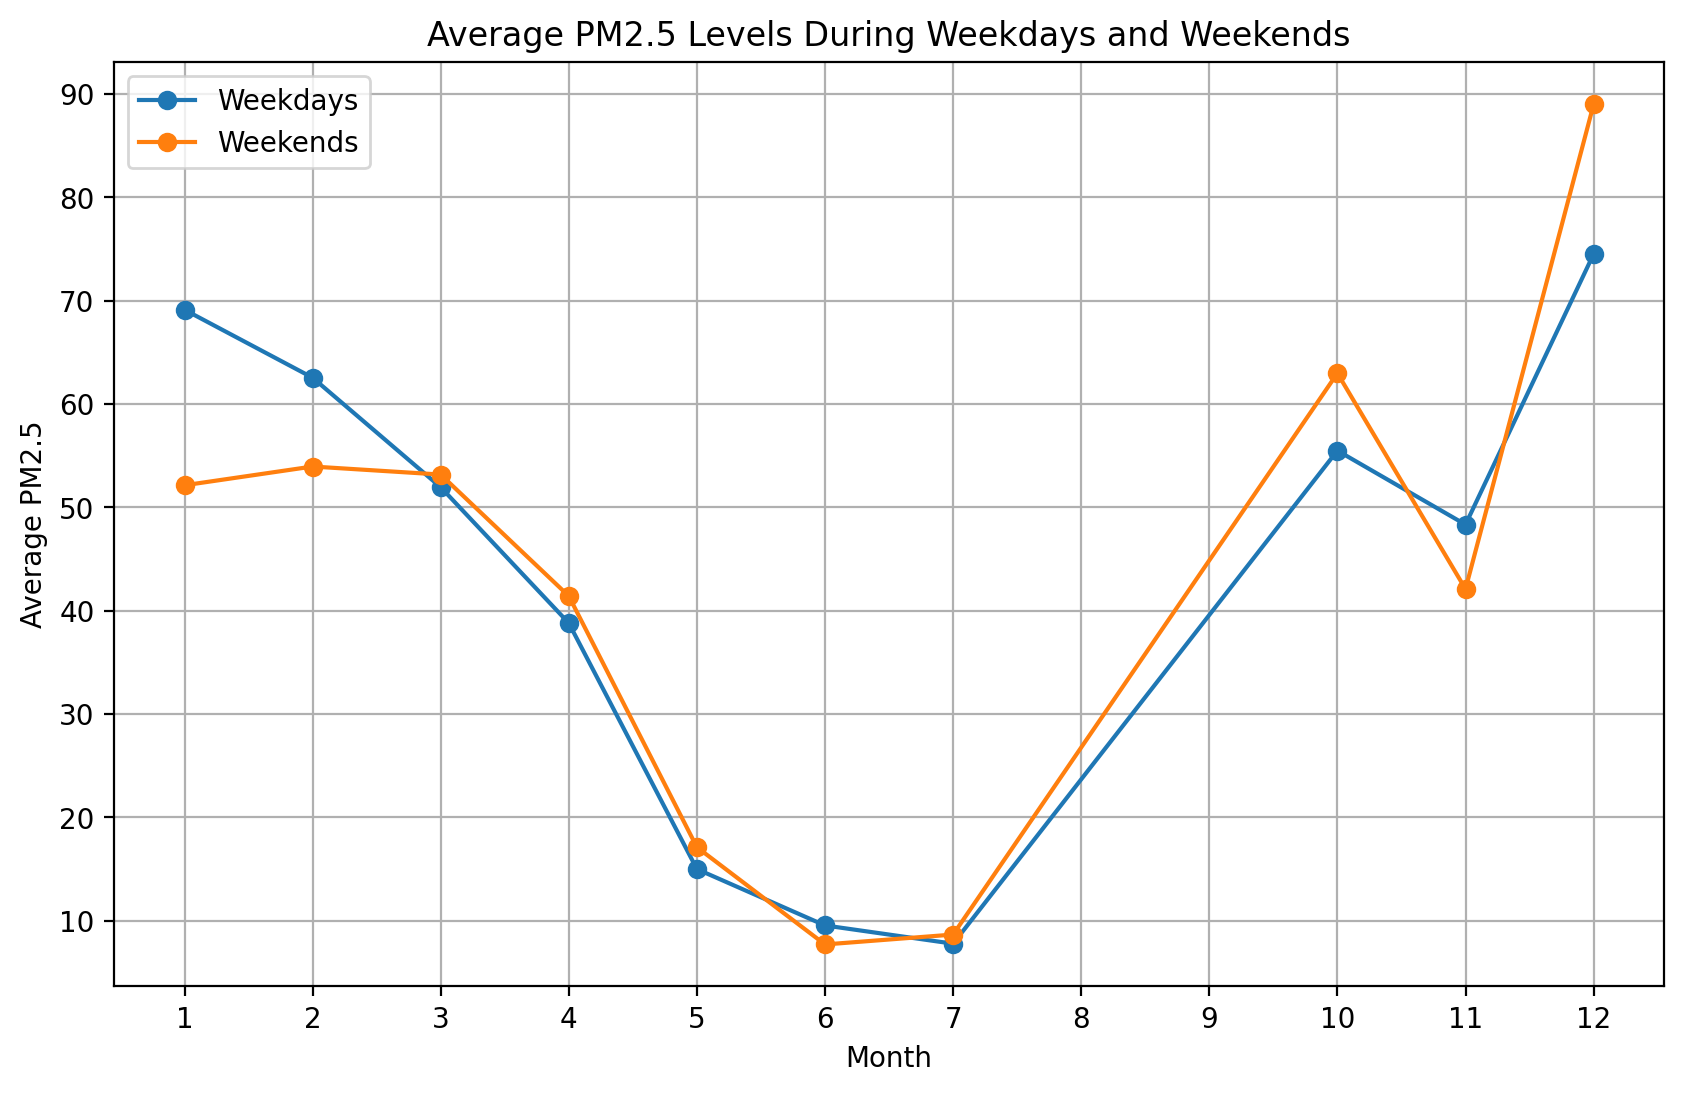

In [ ]:
data["Timestamp"]=pd.to_datetime(data["Timestamp"],errors="coerce")

data_2021=data[(data["Timestamp"].dt.year==2021) & (data["station"]=="Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB")]

data_2021=data_2021.dropna(subset=["PM2.5"])

data_2021["Month"]=data_2021["Timestamp"].dt.month
data_2021["Day of Week"]=data_2021["Timestamp"].dt.dayofweek

weekdays_data=data_2021[data_2021["Day of Week"]<5]
weekends_data=data_2021[data_2021["Day of Week"]>=5]

month_avg_weekdays=weekdays_data.groupby("Month")["PM2.5"].mean()
month_avg_weekends=weekends_data.groupby("Month")["PM2.5"].mean()

plt.figure(figsize=(10,6))
plt.plot(month_avg_weekdays.index, month_avg_weekdays.values, marker='o', linestyle='-', label="Weekdays")
plt.plot(month_avg_weekends.index, month_avg_weekends.values, marker='o', linestyle='-', label="Weekends")
plt.xlabel("Month")
plt.ylabel("Average PM2.5")
plt.title("Average PM2.5 Levels During Weekdays and Weekends")
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.show()

# Spatio-temporal aggregation

1) For each state, calculate the percentage increase or decrease in PM2.5 levels during monsoon months (June to September) compared to summer months (March to May). Which state has the most difference (increase or decrease) for the year 2022?

In [ ]:
data["Timestamp"]=pd.to_datetime(data["Timestamp"],errors="coerce")

data_2022=data[data["Timestamp"].dt.year==2022]

data_2022=data_2022.dropna(subset=["PM2.5"])

data_2022["Month"]=data_2022["Timestamp"].dt.month

data_Monsoon=data_2022[(data_2022["Month"]<=9) & (data_2022["Month"]>=6)]
state_monsoon_data=data_Monsoon.groupby("state")["PM2.5"].mean()

data_Summer=data_2022[(data_2022["Month"]<=5) & (data_2022["Month"]>=3)]
state_summer_data=data_Summer.groupby("state")["PM2.5"].mean()

percent_change=((state_monsoon_data-state_summer_data)/state_summer_data)*100

# Here change for every state is negative so decrement so the most negative value will be the highest change.
max_change_state=percent_change.idxmin()

print(f"The state with the most difference (decrease) for the year 2022 was '{max_change_state}' with {round(abs(percent_change[max_change_state]),4)} % change")

The state with the most difference (decrease) for the year 2022 was 'Assam' with 61.1764 % change


2) Plot the average PM2.5 levels for Delhi across each season (Winter: December-February, Summer: March-May, Monsoon: June-September) from 2017 to 2023. What seasonal variation, if any, can you observe in pollution levels?

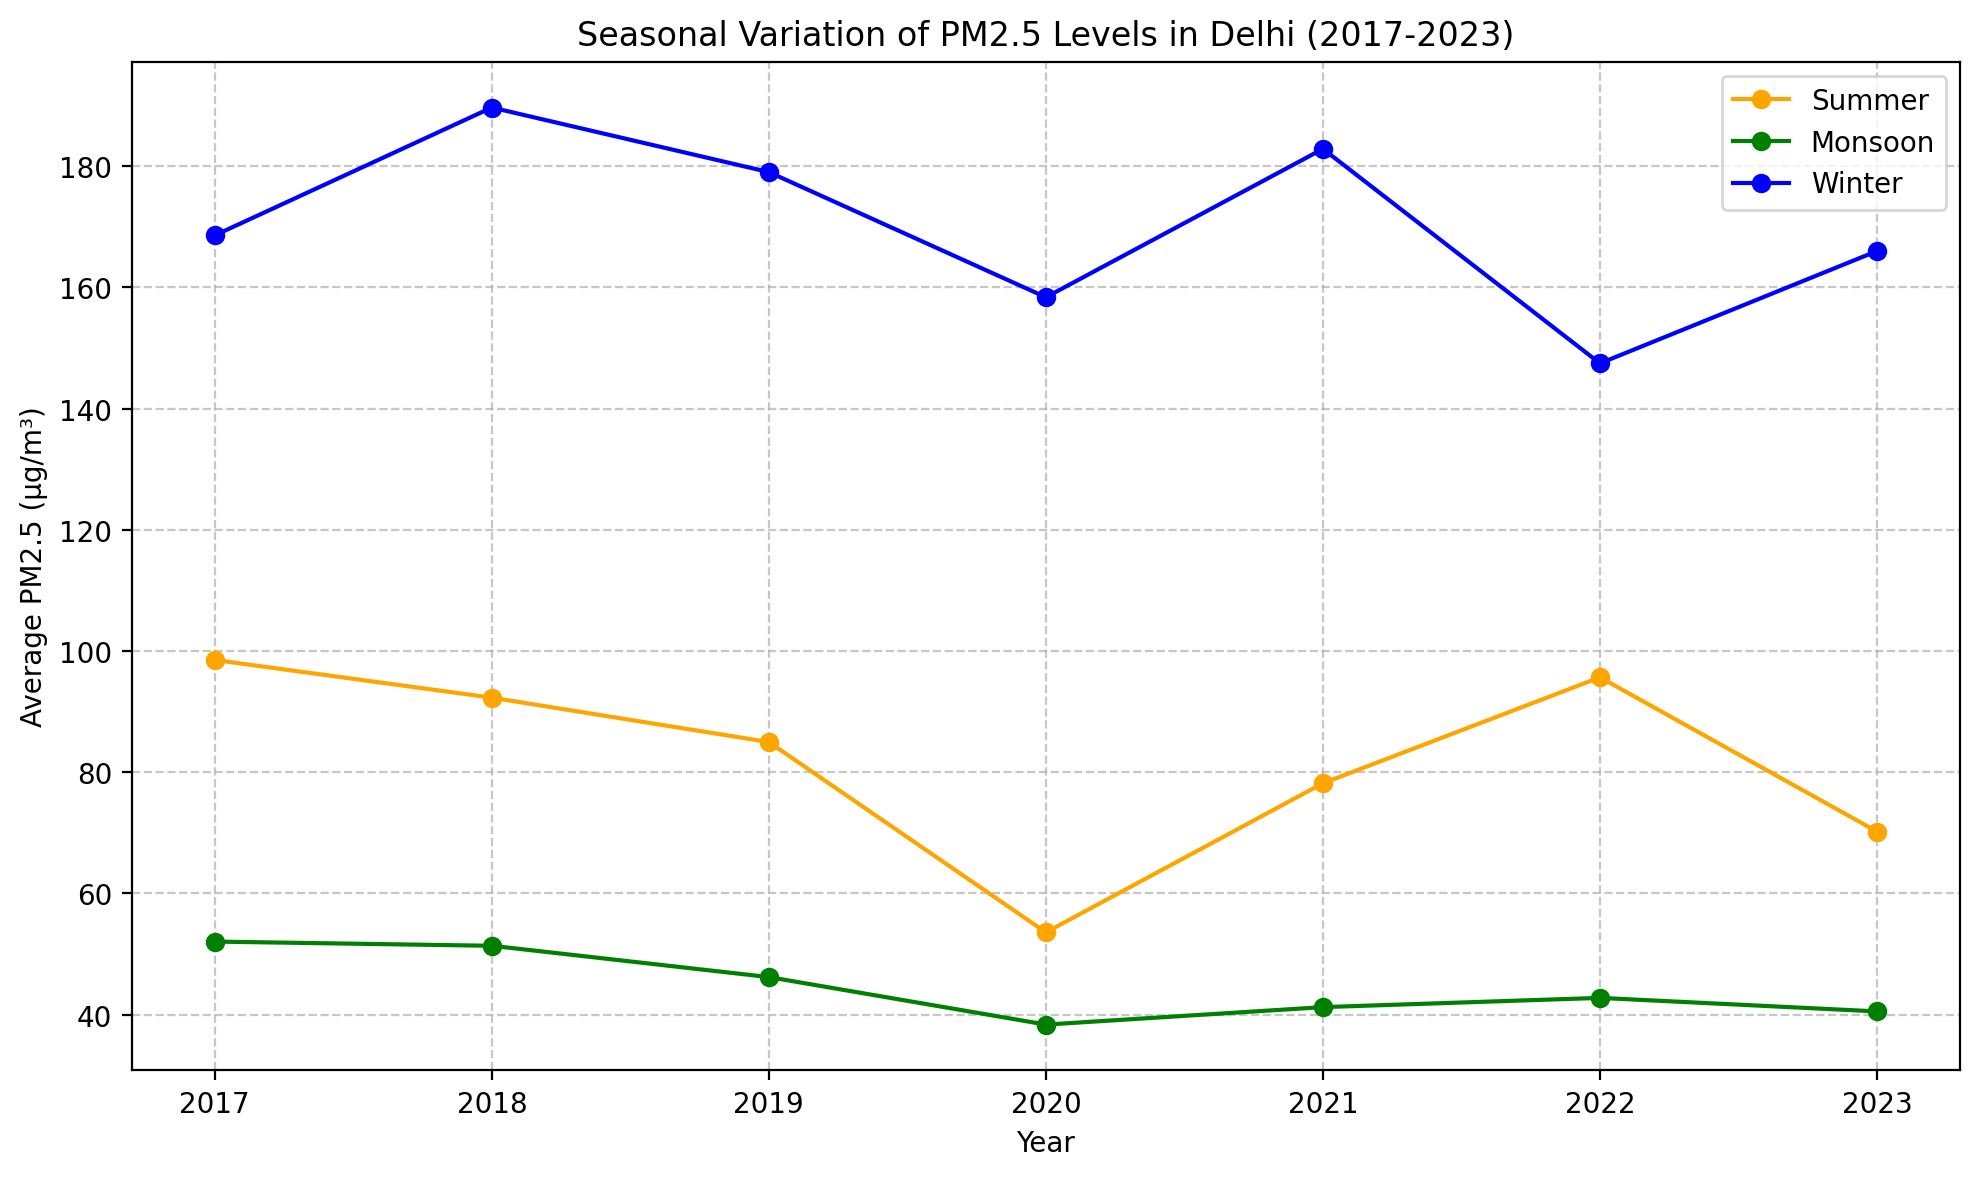

In [ ]:
data["Timestamp"] = pd.to_datetime(data["Timestamp"], errors="coerce")

data_delhi = data[(data["state"] == "Delhi") & (data["Timestamp"].dt.year >= 2017) & (data["Timestamp"].dt.year <= 2023)]

data_delhi = data_delhi.dropna(subset=["PM2.5"])
data_delhi["Month"] = data_delhi["Timestamp"].dt.month

data_delhi_summer = data_delhi[(data_delhi["Month"] >= 3) & (data_delhi["Month"] <= 5)]
data_delhi_monsoon = data_delhi[(data_delhi["Month"] >= 6) & (data_delhi["Month"] <= 9)]
data_delhi_winter = data_delhi[(data_delhi["Month"] == 12) | (data_delhi["Month"] <= 2)]

avg_delhi_summer = data_delhi_summer.groupby(data_delhi_summer["Timestamp"].dt.year)["PM2.5"].mean()
avg_delhi_monsoon = data_delhi_monsoon.groupby(data_delhi_monsoon["Timestamp"].dt.year)["PM2.5"].mean()
avg_delhi_winter = data_delhi_winter.groupby(data_delhi_winter["Timestamp"].dt.year)["PM2.5"].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_delhi_summer.index, avg_delhi_summer.values, label="Summer", marker='o',color="Orange")
plt.plot(avg_delhi_monsoon.index, avg_delhi_monsoon.values, label="Monsoon", marker='o',color="Green")
plt.plot(avg_delhi_winter.index, avg_delhi_winter.values, label="Winter", marker='o',color="Blue")

plt.title("Seasonal Variation of PM2.5 Levels in Delhi (2017-2023)")
plt.xlabel("Year")
plt.ylabel("Average PM2.5 (µg/m³)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Winter: PM2.5 levels are usually highest due to low temperatures, temperature inversion, and increased emissions (heating, burning).
# Summer: PM2.5 levels moderately high but lower than winter due to better air circulation.
# Monsoon: PM2.5 levels are lowest due to rainfall washing pollutants away

3) Plot a time-series graph comparing Delhi’s PM2.5 levels with Mumbai’s from 2015 to 2023. Which city had more fluctuations? (Hint: Think what fluctuation means)

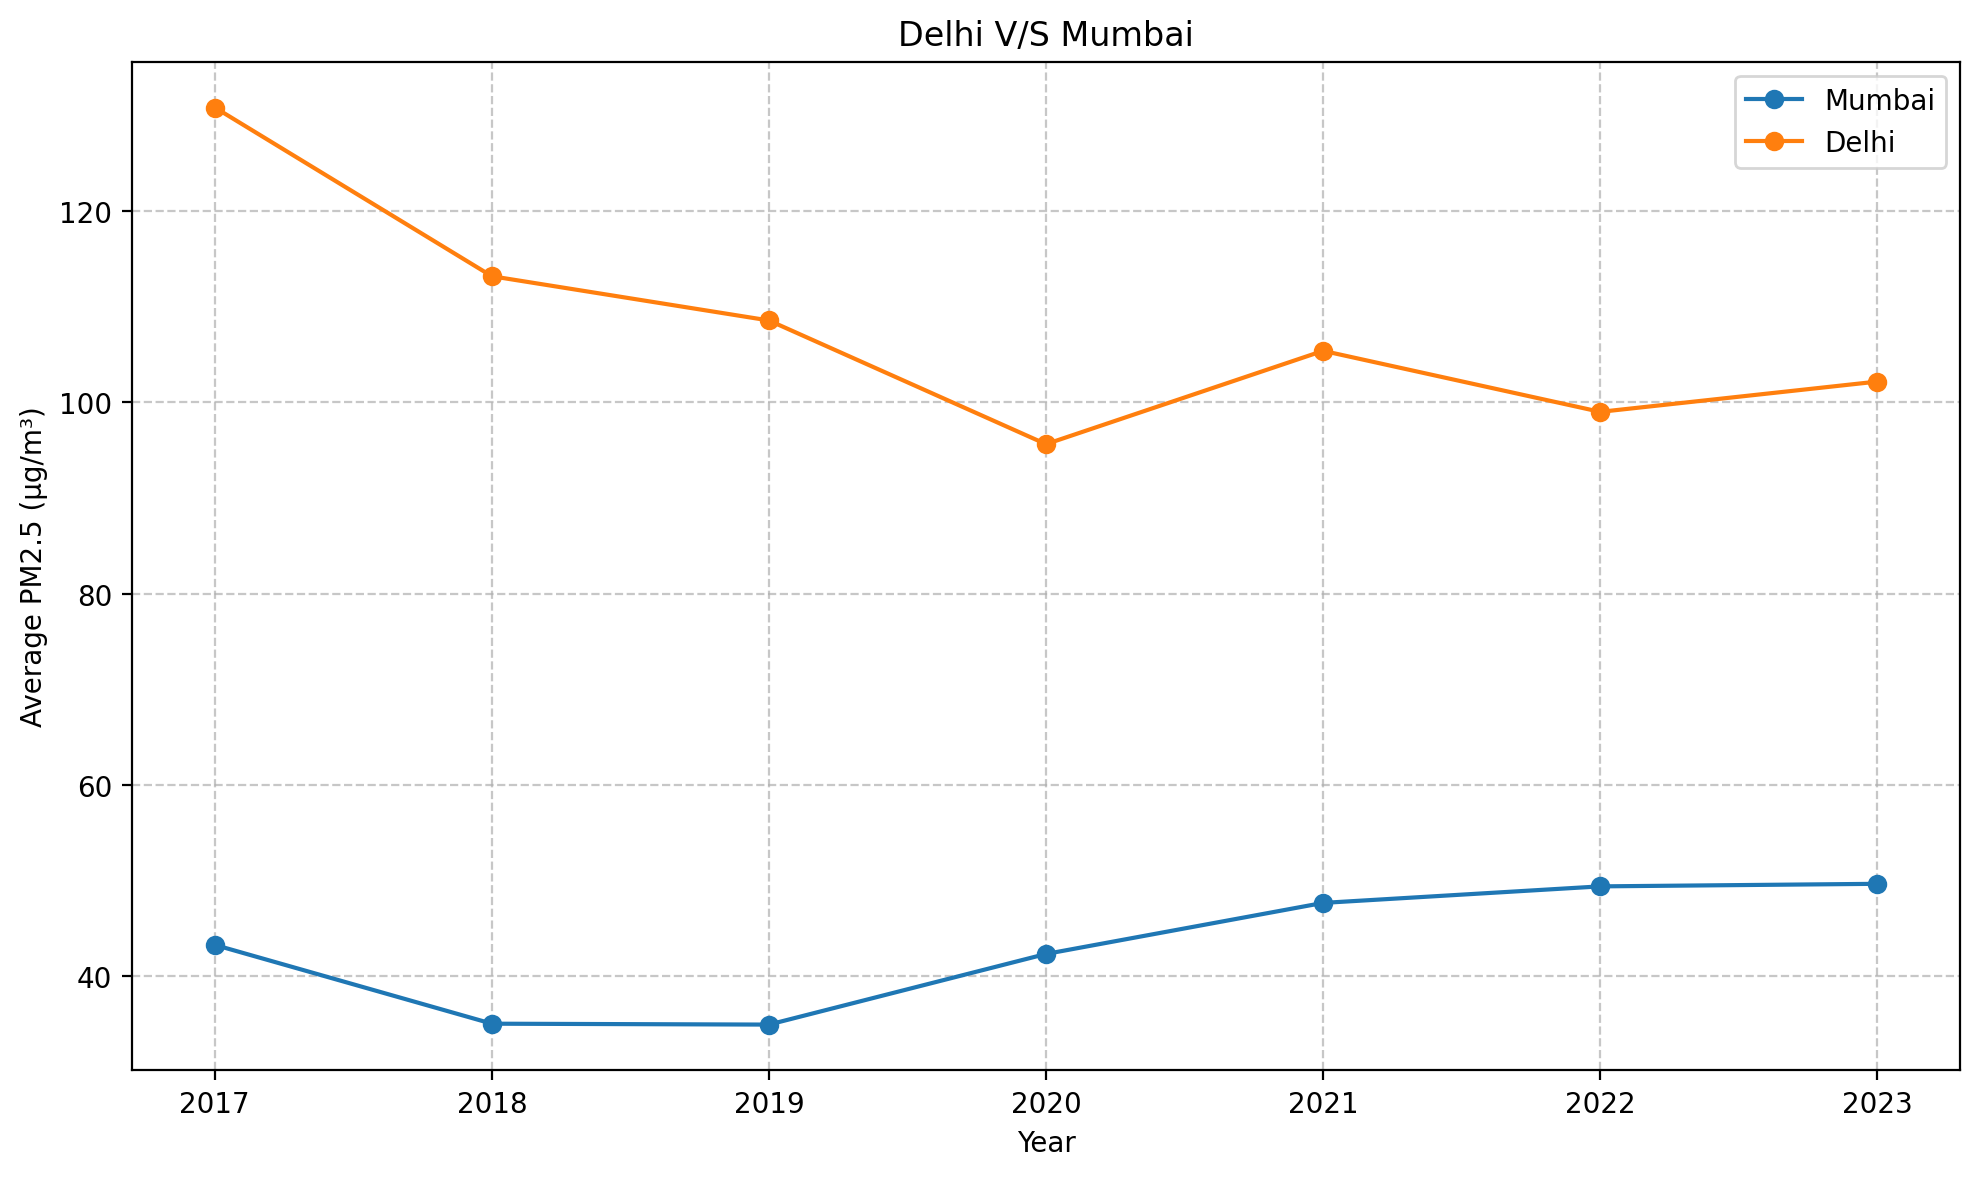

Delhi had more fluctuations


In [ ]:
data["Timestamp"]=pd.to_datetime(data["Timestamp"],errors="coerce")

data_req=data[(data["Timestamp"].dt.year>=2015) & (data["Timestamp"].dt.year<=2023) & ((data["state"]=="Delhi") | (data["city"]=="Mumbai"))]

data_req=data_req.dropna(subset=["PM2.5"])
data_req["Year"]=data_req["Timestamp"].dt.year

avg_mumbai=data_req[data_req["city"]=="Mumbai"].groupby("Year")["PM2.5"].mean()
avg_delhi=data_req[data_req["state"]=="Delhi"].groupby("Year")["PM2.5"].mean()

plt.figure(figsize=(10,6))
plt.plot(avg_mumbai.index,avg_mumbai.values,label="Mumbai",marker="o")
plt.plot(avg_delhi.index,avg_delhi.values,label="Delhi",marker="o")
plt.title("Delhi V/S Mumbai")
plt.xlabel("Year")
plt.ylabel("Average PM2.5 (µg/m³)")
plt.legend()
plt.grid(True,linestyle="--",alpha=0.7)

plt.tight_layout()
plt.show()

state_fluctuations=data_req.groupby("state")["PM2.5"].std()
city_fluctuations=data_req.groupby("city")["PM2.5"].std()

delhi_fluctuation=state_fluctuations["Delhi"]
mumbai_fluctuation=city_fluctuations["Mumbai"]

if delhi_fluctuation>mumbai_fluctuation:
    print("Delhi had more fluctuations")
else:
    print("Mumbai had more fluctuations")

# Population-Based

1) Which state in India has the highest number of monitoring stations relative to its population?

In [ ]:
station_data=data
population_data=State_Data

grouped_station_data=station_data.groupby("state")["station"].count()
#can't find a way to find unique station in state
grouped_population_data=population_data.groupby("State")["Population"].sum()
relative_data=grouped_station_data/grouped_population_data

max_relative_state=relative_data.idxmax()

print(f"The state with the highest number of monitoring stations relative to its population was '{max_relative_state}'")

The state with the highest number of monitoring stations relative to its population was 'Chandigarh'


2) Plot a bar chart showing the top 5 most polluted states in terms of per capita PM2.5 exposure in 2023.

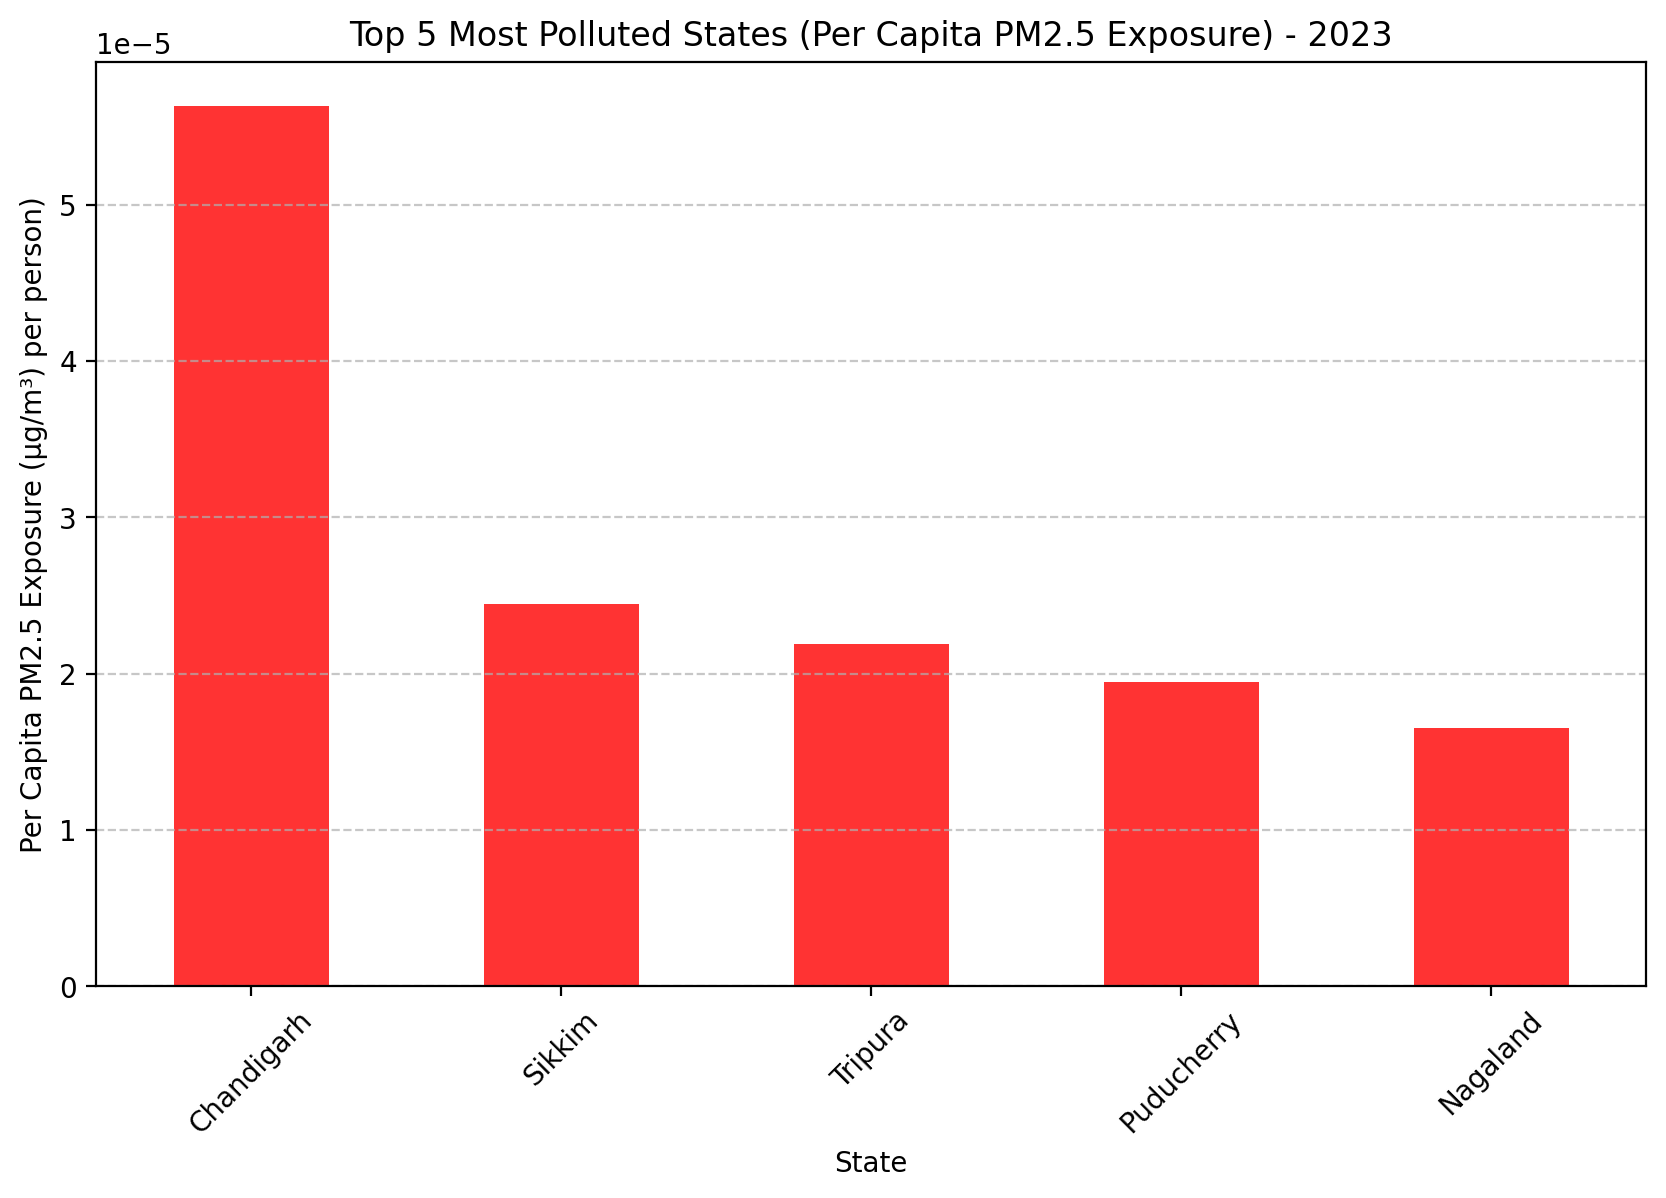

In [ ]:
state_data=State_Data

data["Timestamp"]=pd.to_datetime(data["Timestamp"],errors="coerce")

data_2023=data[data["Timestamp"].dt.year==2023]
data_2023=data_2023.dropna(subset=["PM2.5"])

pollu_state_data=data_2023.groupby("state")["PM2.5"].mean()
population_data=state_data.groupby("State")["Population"].sum()

per_capita_data=pollu_state_data/population_data
top_5=per_capita_data.sort_values(ascending=False).head(5)

plt.figure(figsize=(10, 6))
top_5.plot(kind="bar", color="red", alpha=0.8)
plt.title("Top 5 Most Polluted States (Per Capita PM2.5 Exposure) - 2023")
plt.xlabel("State")
plt.ylabel("Per Capita PM2.5 Exposure (µg/m³) per person)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45)

plt.show()

3) Plot the relationship between population density and average PM2.5 concentration for each state. What conclusion can you draw about the correlation between population density and pollution?
X-axis: Population density (people per square kilometer).
Y-axis: Average PM2.5 concentration.
Use a scatter plot to show the relationship, where each point represents a state.`

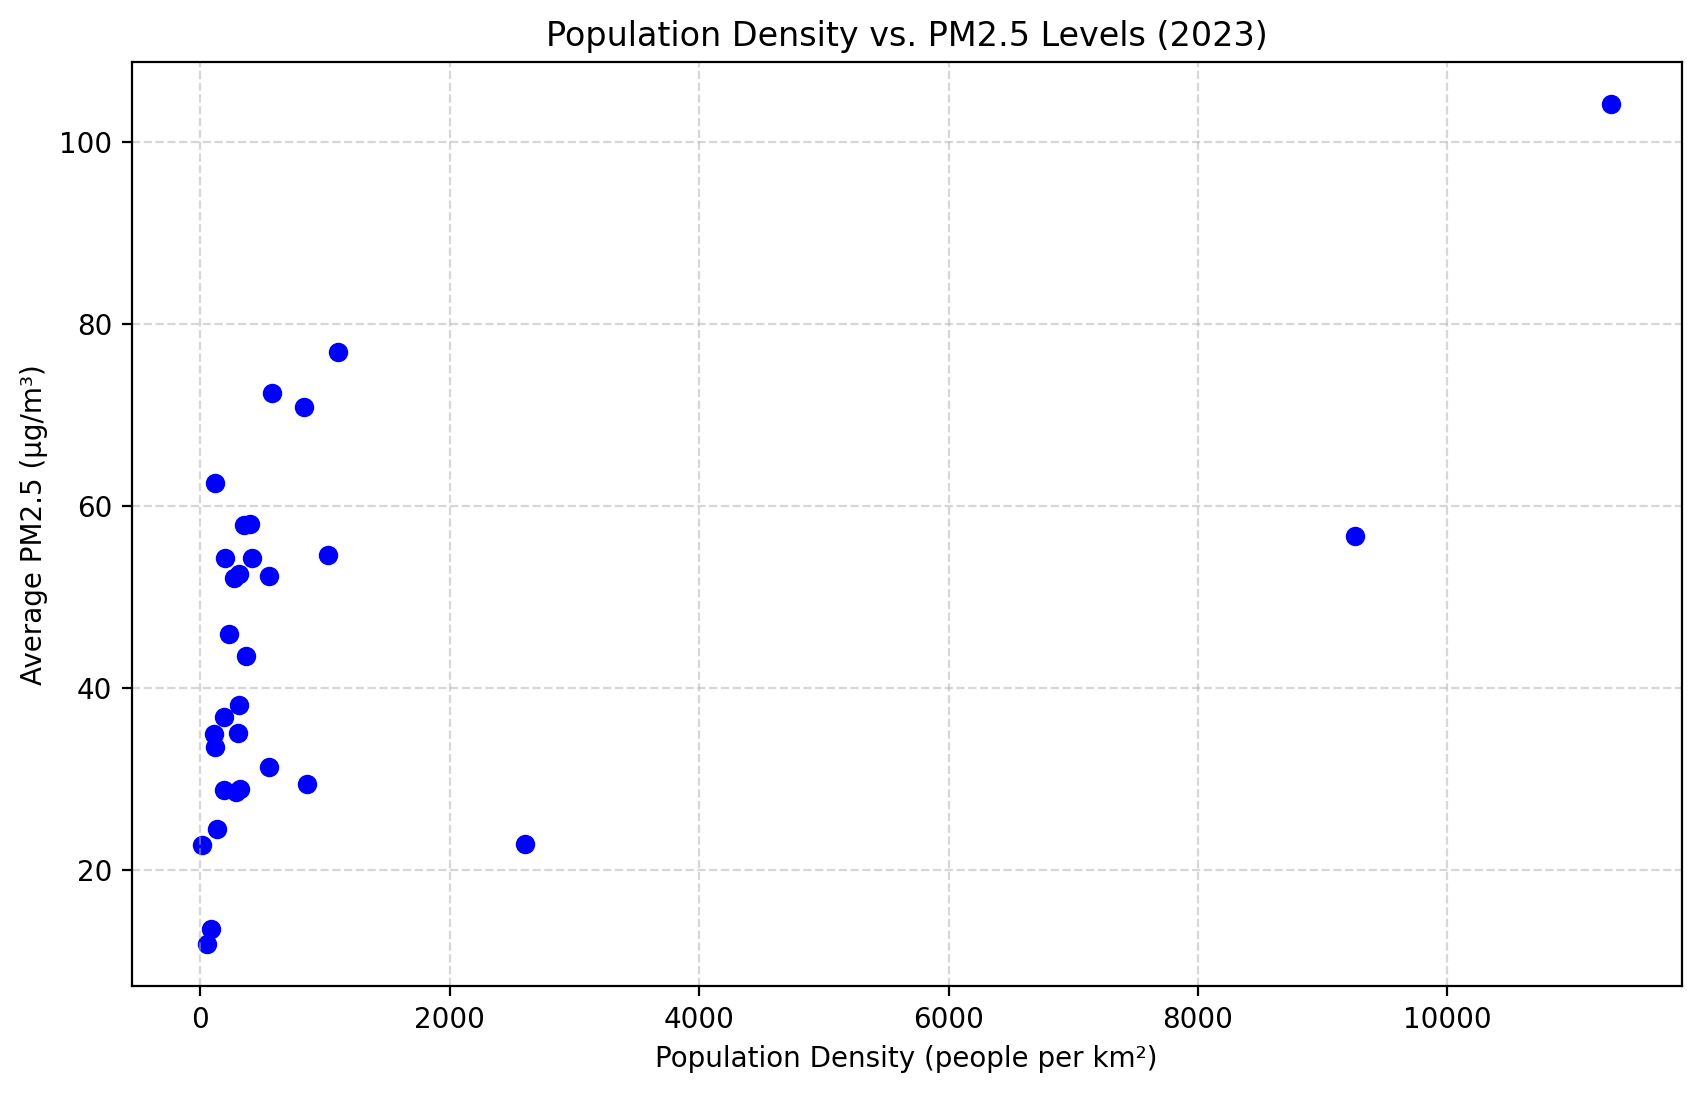

In [ ]:
state_data=State_Data

pollu_state_data=data.groupby("state")["PM2.5"].mean()
population_data=state_data.groupby("State")["Population"].sum()
area_data=state_data.groupby("State")["Area (km2)"].sum()

population_density=population_data/area_data

plt.figure(figsize=(10, 6))
plt.scatter(population_density, pollu_state_data, color="blue")

plt.xlabel("Population Density (people per km²)")
plt.ylabel("Average PM2.5 (µg/m³)")
plt.title("Population Density vs. PM2.5 Levels (2023)")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

# Area Based

1) Which state has the highest PM2.5 concentration per square kilometer? Plot the pollution levels for all states relative to their area.
X-axis: States.
Y-axis: PM2.5 concentration per square kilometer.
Use a bar plot where each bar represents a state, and the height shows PM2.5 per sq km.

The state with the highest PM2.5 concentration per square kilometer is 'Chandigarh'


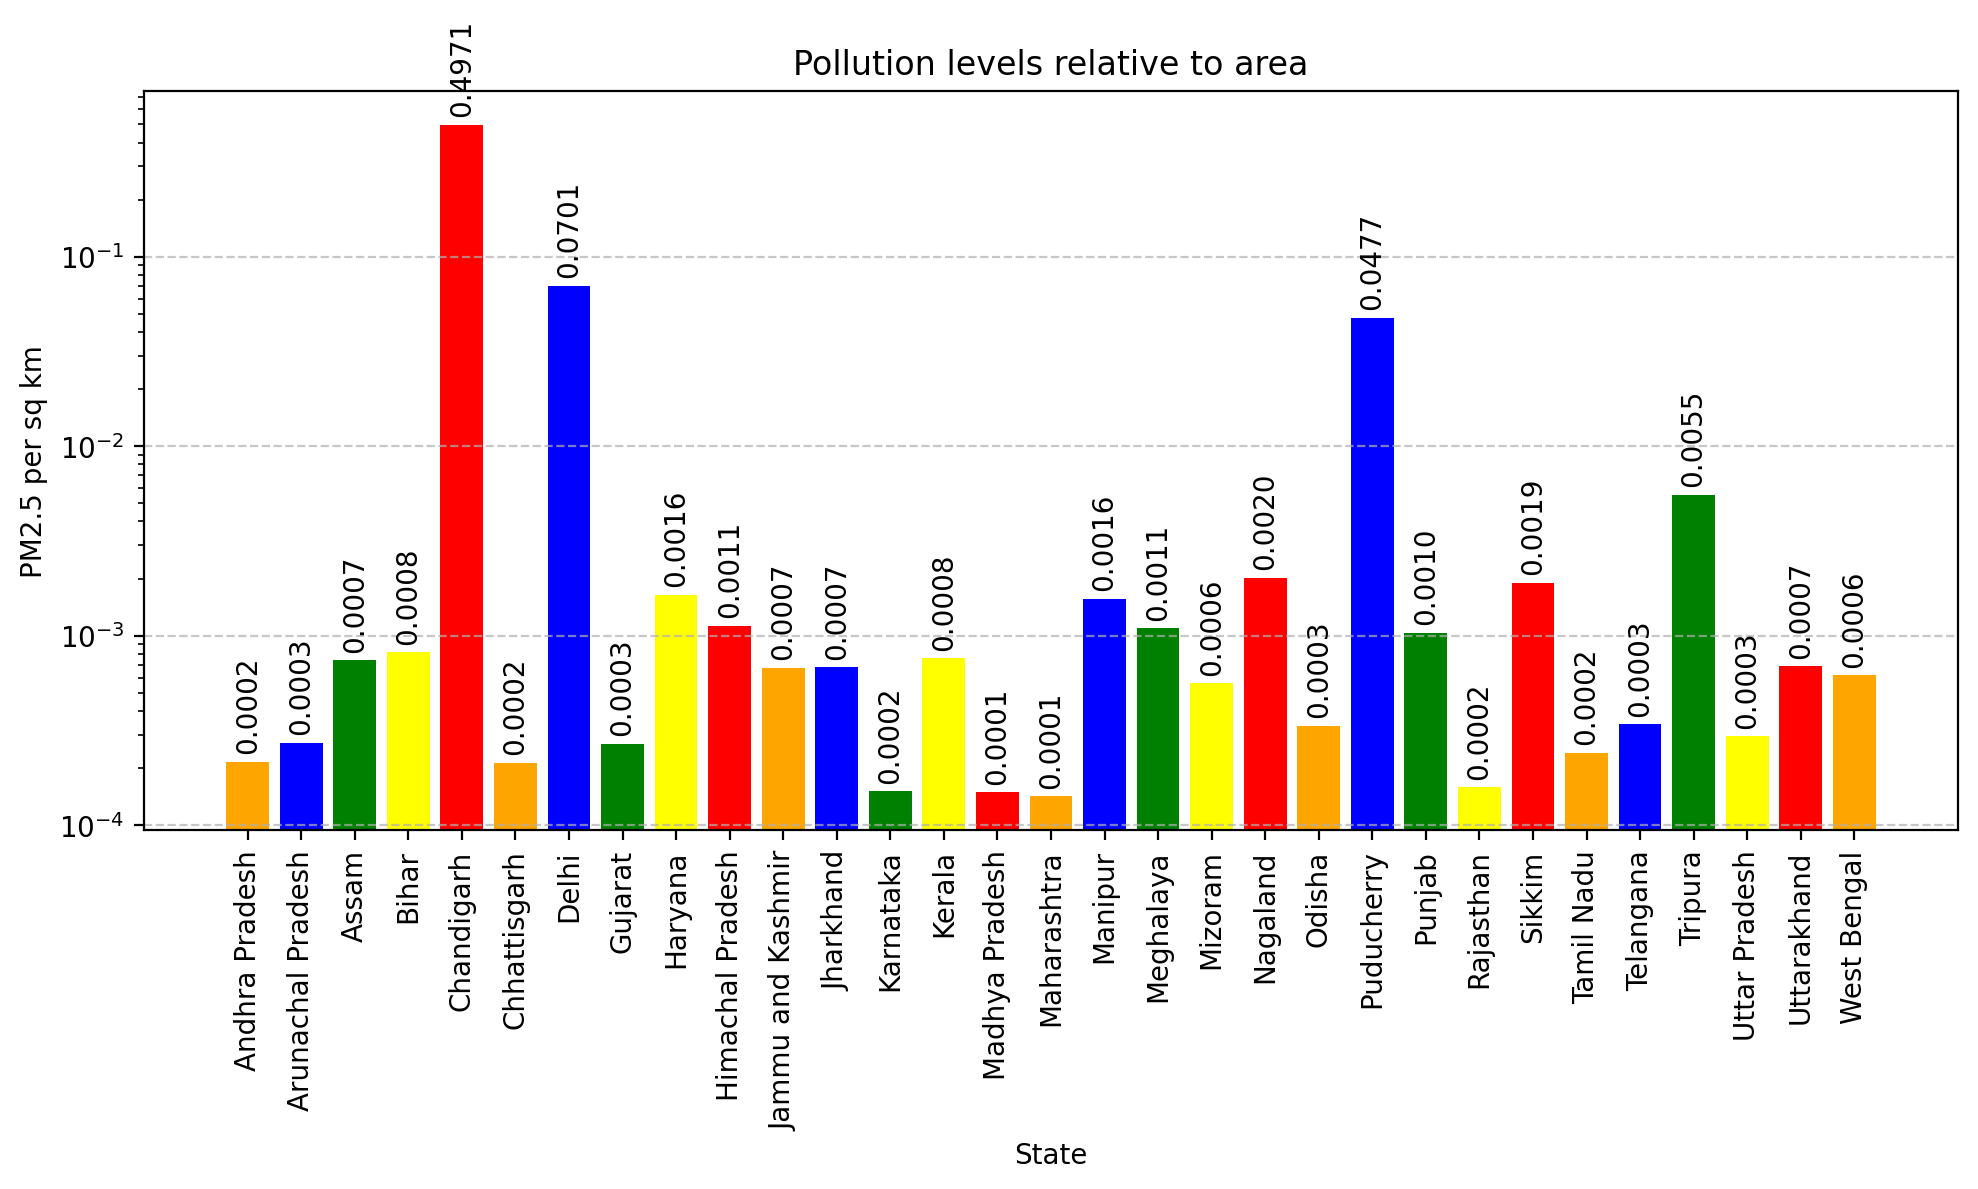

In [ ]:
state_data=State_Data

pollu_state_data=data.groupby("state")["PM2.5"].mean()
area_data=state_data.groupby("State")["Area (km2)"].sum()

pollu_per_sq_km=pollu_state_data/area_data
max_pollu_state=pollu_per_sq_km.idxmax()
print(f"The state with the highest PM2.5 concentration per square kilometer is '{max_pollu_state}'")

plt.figure(figsize=(10,6))
colors=["Orange","Blue","Green","Yellow","Red"]
bars=plt.bar(pollu_per_sq_km.index,pollu_per_sq_km.values,color=colors)
plt.bar_label(bars, fmt="%.4f", label_type="edge", fontsize=10, rotation=90, padding=3)
plt.yscale("log")
plt.title("Pollution levels relative to area")
plt.xlabel("State")
plt.ylabel("PM2.5 per sq km")
plt.grid(axis="y",linestyle="--",alpha=0.7)
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

2) Compare the total number of monitoring stations per square kilometer in each state. Identify the state with the highest density of monitoring stations relative to its area. Show a bar plot where each bar represents a state, and the height shows the number of monitoring stations per square kilometer.

The state with the highest density of monitoring stations relative to its area is 'Delhi'


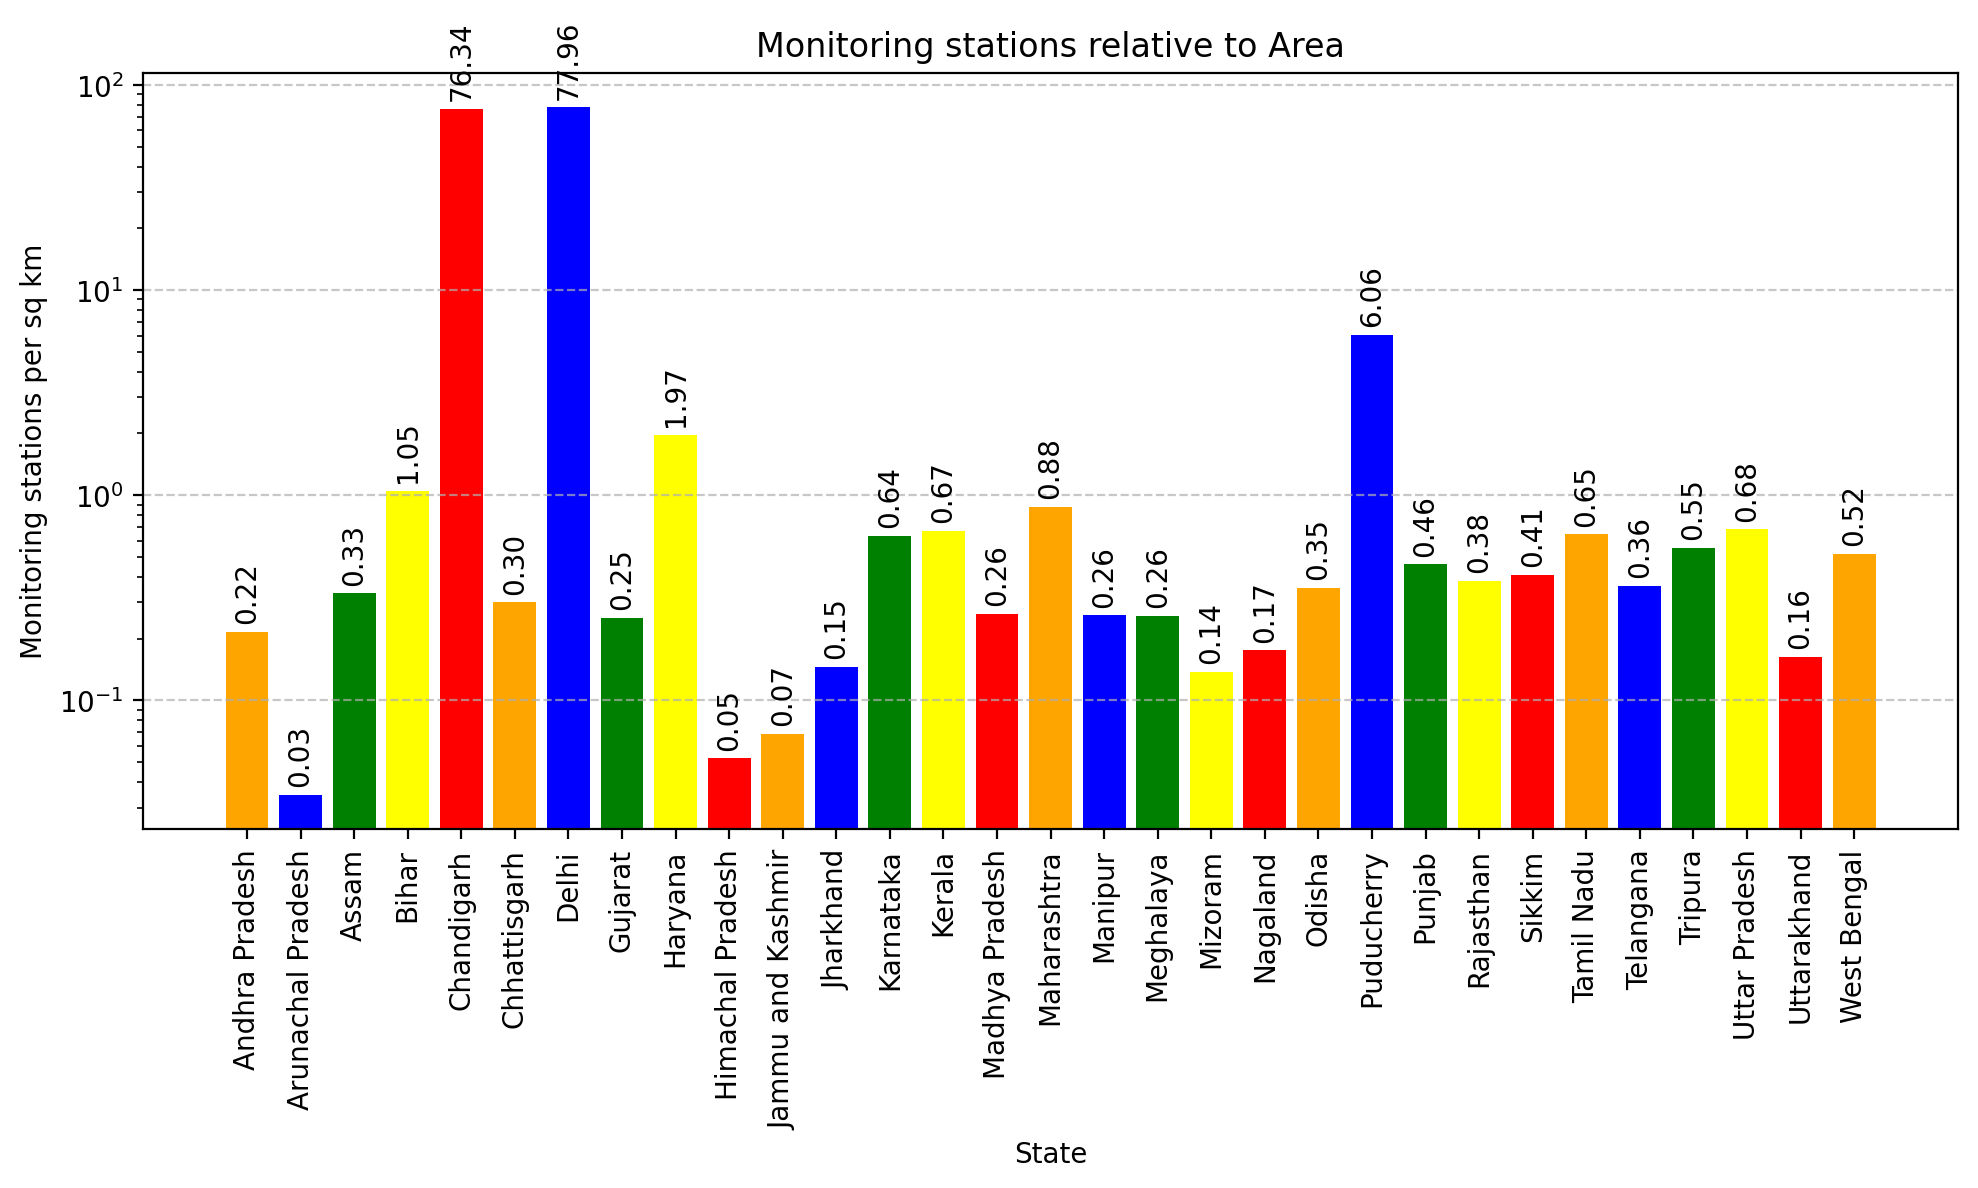

In [ ]:
state_data=State_Data

station_data=data.groupby("state")["station"].count()
area_data=state_data.groupby("State")["Area (km2)"].sum()

station_per_sq_km=station_data/area_data

max_station_state=station_per_sq_km.idxmax()

print(f"The state with the highest density of monitoring stations relative to its area is '{max_station_state}'")

plt.figure(figsize=(10,6))
colors=["Orange","Blue","Green","Yellow","Red"]
bars=plt.bar(station_per_sq_km.index,station_per_sq_km.values,color=colors)
plt.bar_label(bars, fmt="%.2f", label_type="edge", fontsize=10, rotation=90, padding=3)
plt.yscale("log")
plt.title("Monitoring stations relative to Area")
plt.xlabel("State")
plt.ylabel("Monitoring stations per sq km")
plt.grid(axis="y",linestyle="--",alpha=0.7)
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

3) Compare the average PM2.5 levels between Maharashtra and Madhya Pradesh over the year 2021. Given that both states have similar area sizes but different population densities, analyze how population density impacts pollution levels in these two states.

In [ ]:
state_data=State_Data

data["Timestamp"]=pd.to_datetime(data["Timestamp"],errors="coerce")

data_2021=data[data["Timestamp"].dt.year==2021]
data_2021=data_2021.dropna(subset=["PM2.5"])

grouped_data=data_2021.groupby("state")["PM2.5"].mean()

maharashtra_data=grouped_data["Maharashtra"]
madhya_pradesh_data=grouped_data["Madhya Pradesh"]

print(f"Average PM2.5 levels in Maharashtra in 2021: {maharashtra_data}")
print(f"Average PM2.5 levels in Madhya Pradesh in 2021: {madhya_pradesh_data}")

state_population=state_data.groupby("State")["Population"].sum()
maharashtra_population=state_population["Maharashtra"]
madhya_pradesh_population=state_population["Madhya Pradesh"]

area_data=state_data.groupby("State")["Area (km2)"].sum()
maharashtra_area=area_data["Maharashtra"]
madhya_pradesh_area=area_data["Madhya Pradesh"]

population_density_maharashtra=maharashtra_population/maharashtra_area
population_density_madhya_pradesh=madhya_pradesh_population/madhya_pradesh_area

print(f"Population density in Maharashtra: {population_density_maharashtra}")
print(f"Population density in Madhya Pradesh: {population_density_madhya_pradesh}")

Average PM2.5 levels in Maharashtra in 2021: 46.44004417107664
Average PM2.5 levels in Madhya Pradesh in 2021: 47.095951831498965
Population density in Maharashtra: 365.1920230864474
Population density in Madhya Pradesh: 235.60855728429985


As we can see Madhya pradesh has population density 235.608557 and that of Maharashtra is 365.192023 Population of Maharashtra is more than MP although they have similar size we can conclude that more the population density more will be the pollution level is not true as we can see in Madhya Pradesh average PM 2.5 is higher than Maharashtra. Major cause of that is industries and manufacturing units.


# Funding Based

1) Compare the average PM2.5 levels between states that received NCAP funding and those that did not in 2021.

In [ ]:
state_data=State_Data
funding_data=NCAP_Funding

data["Timestamp"] = pd.to_datetime(data["Timestamp"], errors="coerce")
data["Year"]=data["Timestamp"].dt.year

funding_2021 = funding_data[funding_data["Amount released during FY 2021-22"] != "-"]

funded_states_2021 = set(funding_2021["State"])

funded_pollution = data[data["state"].isin(funded_states_2021)]
non_funded_pollution = data[~data["state"].isin(funded_states_2021)]

avg_pm25_funded = funded_pollution["PM2.5"].mean()
avg_pm25_not_funded = non_funded_pollution["PM2.5"].mean()

print(f"Average PM2.5 in NCAP funded states (2021): {avg_pm25_funded:.2f}")
print(f"Average PM2.5 in non-funded states (2021): {avg_pm25_not_funded:.2f}")

Average PM2.5 in NCAP funded states (2021): 62.07
Average PM2.5 in non-funded states (2021): 52.87


*Thus* we can conclude that average pm2.5 for funding recieving states is higher than that of non receving states.

2) Create a time series plot showing PM2.5 levels with an increment in NCAP funding for Assam. Has an increment of the financing led to noticeable improvements in air quality?

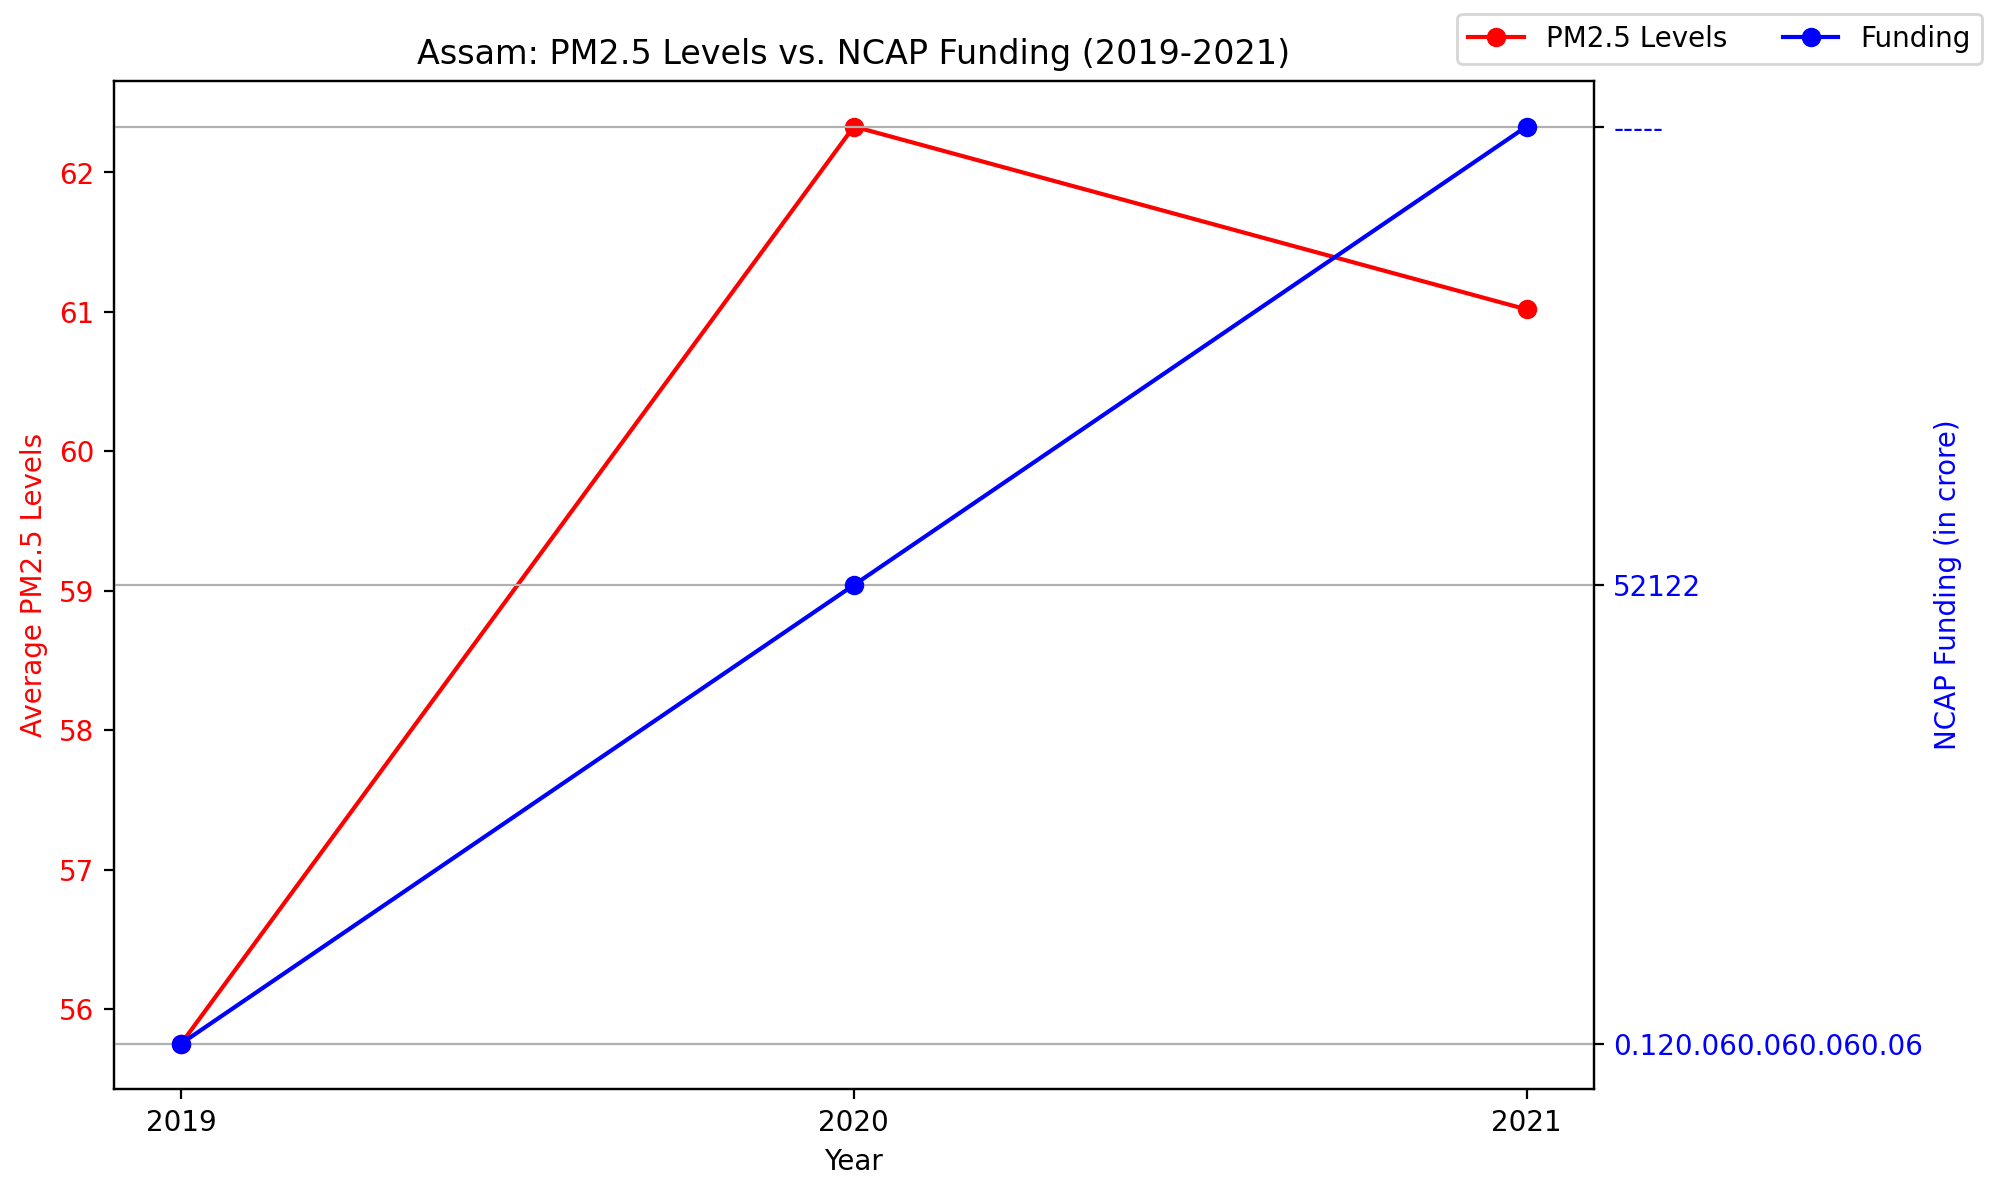

In [ ]:
assam_funding = funding_data[funding_data['State'] == 'Assam']

data["Timestamp"] = pd.to_datetime(data["Timestamp"], errors="coerce")
data["Year"]=data["Timestamp"].dt.year

data_2019 = data[data['Year'] == 2019]
data_2020 = data[data['Year'] == 2020]


assam_19 = assam_funding.groupby('State')['Amount released during FY 2019-20'].sum().values[0]
assam_20 = assam_funding.groupby('State')['Amount released during FY 2020-21'].sum().values[0]
assam_21 = assam_funding.groupby('State')['Amount released during FY 2021-22'].sum().values[0]

assam_pm2_19 = data_2019[data_2019['state'] == 'Assam']['PM2.5'].mean()
assam_pm2_20 = data_2020[data_2020['state'] == 'Assam']['PM2.5'].mean()
assam_pm2_21 = data_2021[data_2021['state'] == 'Assam']['PM2.5'].mean()


years = [2019, 2020, 2021]
funding_values = [assam_19, assam_20, assam_21]
pm25_values = [assam_pm2_19, assam_pm2_20, assam_pm2_21]

fig, ax1 = plt.subplots(figsize = (10, 6))

ax1.plot(years, pm25_values, label = 'PM2.5 Levels', color = 'red', marker = 'o')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average PM2.5 Levels', color='red')
ax1.tick_params(axis = 'y', labelcolor = 'red')
ax1.set_xticks(years)

ax2 = ax1.twinx()
ax2.plot(years, funding_values, label = 'Funding', color = 'blue', marker = 'o')
ax2.set_ylabel('NCAP Funding (in crore)', color = 'blue')
ax2.tick_params(axis = 'y', labelcolor = 'blue')

plt.title('Assam: PM2.5 Levels vs. NCAP Funding (2019-2021)')
fig.legend(loc = "upper right", ncol = 2)
plt.grid(True)
plt.tight_layout()
plt.show()


3) Create a scatter plot to showcase the area versus funding received by a state. Mark every state with a different color and show the legend outside the plot.

               State  Total fund released  Area (km2)
0     Andhra Pradesh                35.12      162975
1              Assam                12.36       78438
2              Bihar                21.60       94163
3         Chandigarh                17.89         114
4       Chhattisgarh                13.06      135192
5              Delhi                11.25        1484
6            Gujarat                12.00      196024
7   Himachal Pradesh                10.72       55673
8          Jharkhand                 6.00       79716
9          Karnataka                15.14      191791
10    Madhya Pradesh                27.14      308252
11       Maharashtra                63.15      307713
12         Meghalaya                 3.00       22429
13          Nagaland                 7.05       16579
14            Odisha                15.86      155707
15            Punjab                27.52       50362
16         Rajasthan                21.92      342239
17        Tamil Nadu        

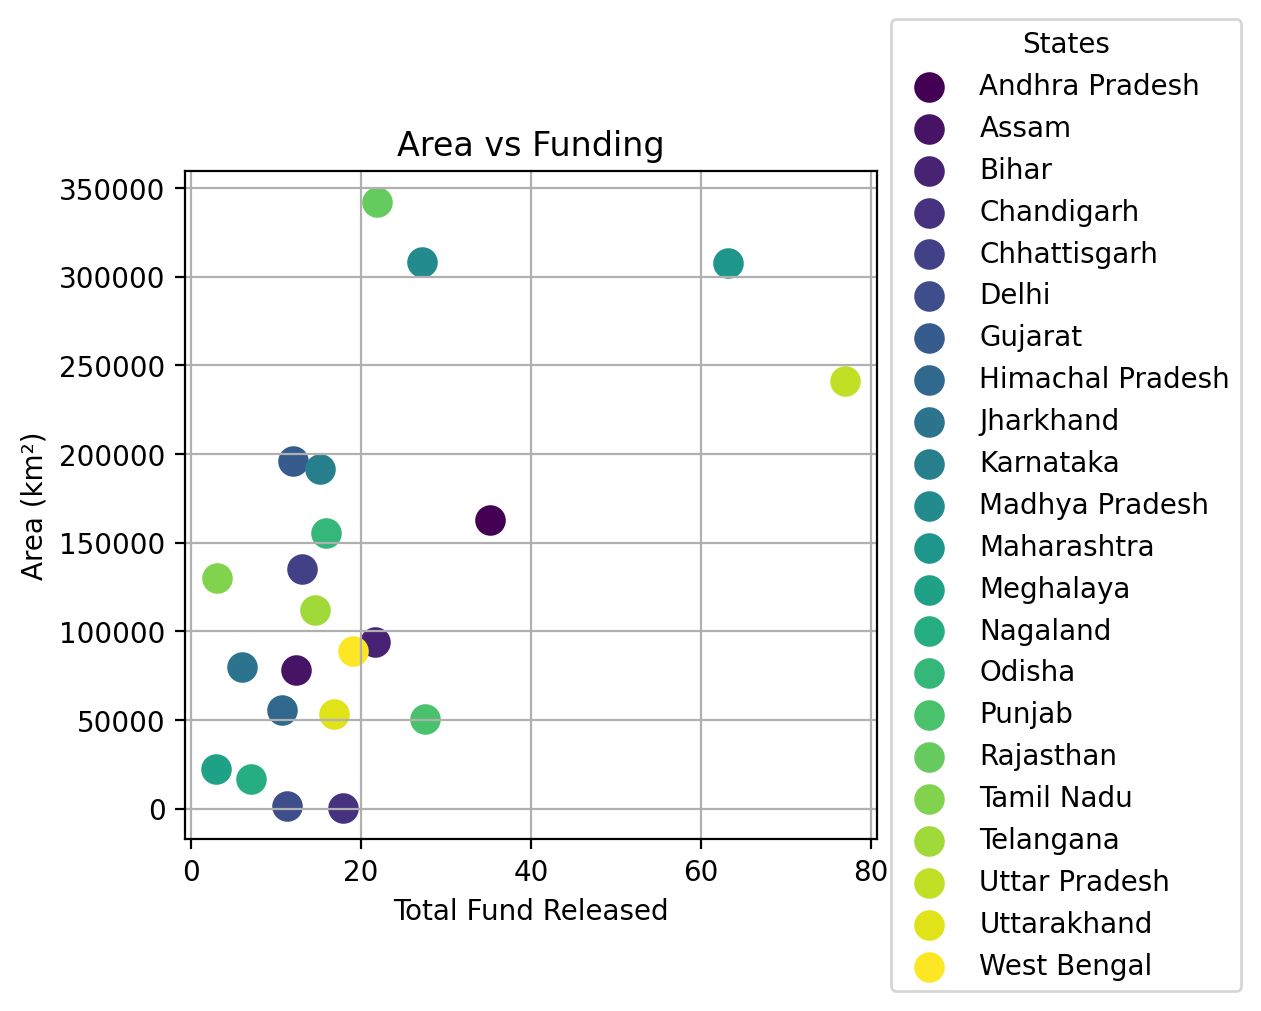

In [ ]:
state_funding=NCAP_Funding.groupby('State')['Total fund released'].sum().reset_index()

area_data=State_Data.groupby('State')['Area (km2)'].sum().reset_index()
state_funding=state_funding.merge(area_data, left_on='State', right_on='State', how='inner')
print(state_funding)

colors = np.linspace(0, 1, len(state_funding))  # Generate color values
colormap = plt.cm.viridis

for i in range(len(state_funding)):
    plt.scatter(
        state_funding['Total fund released'][i],
        state_funding['Area (km2)'][i],
        color=colormap(colors[i]),
        label=state_funding['State'][i],
        s=100  # Marker size
    )

plt.xlabel('Total Fund Released')
plt.ylabel('Area (km²)')
plt.title('Area vs Funding')
plt.grid()

# Add legend outside the plot for better visibility
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='States')

# Show the plot
plt.tight_layout()
plt.show()

# Miscellaneous Questions

1) For the most polluted city in 2023 (highest average pollution in 2023), calculate the percentage of days with PM2.5 levels above the hazardous threshold (300 µg/m³)[1 Mark]

In [ ]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

data_2023 = data[data['Timestamp'].dt.year == 2023].dropna(subset=['PM2.5', 'city'])

most_polluted_city = data_2023.groupby('city')['PM2.5'].mean().idxmax()

daily_avg_pm25 = data_2023[data_2023['city'] == most_polluted_city].groupby(data_2023['Timestamp'].dt.date)['PM2.5'].mean()

hazardous_percentage = (daily_avg_pm25 > 300).mean() * 100

print(f"Most Polluted City in 2023: {most_polluted_city}")
print(f"Percentage of Hazardous Days (>300 µg/m³): {hazardous_percentage:.2f}%")

Most Polluted City in 2023: Darbhanga
Percentage of Hazardous Days (>300 µg/m³): 23.08%


2) Analyze the PM2.5 levels in Delhi during Diwali (October-November) and New Year compared to regular months over the 3 years (2018-2020). Do you observe any significant pollution spikes during these festivals? If spikes are observed, Can you mark these spikes using arrows?

<ipython-input-64-7f46f482e246>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diwali_del['Timestamp'] = pd.to_datetime(data_diwali_del['Timestamp'],errors="coerce")
<ipython-input-64-7f46f482e246>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rmonths_del['Timestamp'] = pd.to_datetime(data_rmonths_del['Timestamp'],errors="coerce")
<ipython-input-64-7f46f482e246>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

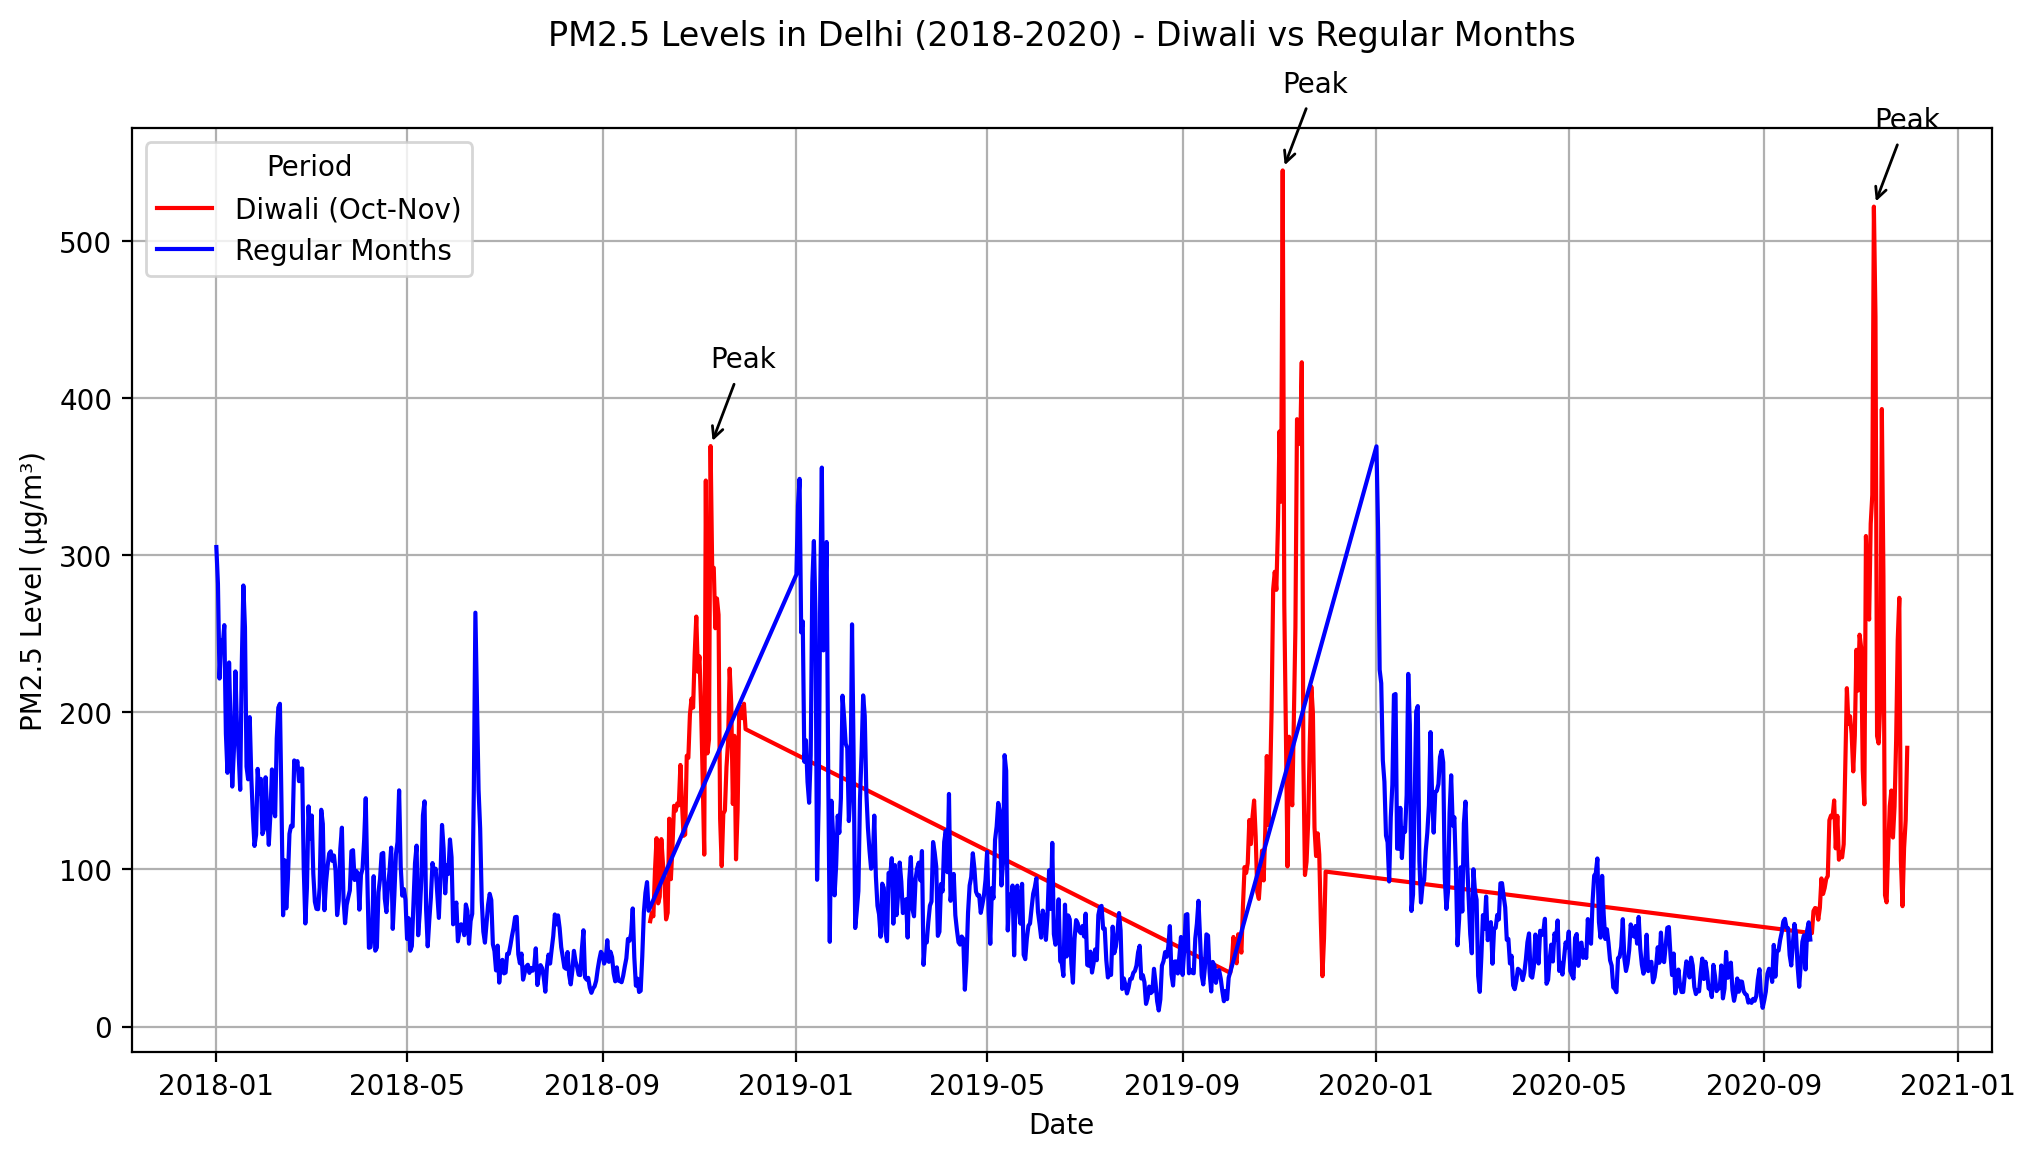

In [ ]:
data_delhi = data[data['state'] == 'Delhi']
data_diwali_del = data_delhi[(data_delhi['Timestamp'].dt.month == 10) | (data_delhi['Timestamp'].dt.month == 11)]
data_rmonths_del = data_delhi[data_delhi['Timestamp'].dt.month.isin([1, 2, 3, 4, 5, 6, 7, 8, 9])]

data_diwali_del['Timestamp'] = pd.to_datetime(data_diwali_del['Timestamp'],errors="coerce")
data_rmonths_del['Timestamp'] = pd.to_datetime(data_rmonths_del['Timestamp'],errors="coerce")

data_diwali_del["Year"]=data_diwali_del["Timestamp"].dt.year
data_rmonths_del["Year"]=data_rmonths_del["Timestamp"].dt.year

diwali_3years = data_diwali_del[(data_diwali_del['Year'] >= 2018) & (data_diwali_del['Year'] <= 2020)]
rmonths_3years = data_rmonths_del[(data_rmonths_del['Year'] >= 2018) & (data_rmonths_del['Year'] <= 2020)]

diwali_avg_pm = diwali_3years.groupby(diwali_3years['Timestamp'].dt.date)['PM2.5'].mean()
rmonths_avg_pm = rmonths_3years.groupby(rmonths_3years['Timestamp'].dt.date)['PM2.5'].mean()

plt.figure(figsize=(12, 6))
diwali_avg_pm.plot(label = 'Diwali (Oct-Nov)', color = 'red')
rmonths_avg_pm.plot(label = 'Regular Months', color = 'blue')

for Year in [2018, 2019, 2020]:
    data_diwali_Year = diwali_3years[diwali_3years['Year'] == Year]
    diwali_avg_pm_Year = data_diwali_Year.groupby(data_diwali_Year['Timestamp'].dt.date)['PM2.5'].mean()
    spike_date_Year = diwali_avg_pm_Year.idxmax()
    spike_value_Year = diwali_avg_pm_Year.max()

    plt.annotate('Peak', xy = (spike_date_Year, spike_value_Year), xytext = (spike_date_Year, spike_value_Year + 50), arrowprops = dict(facecolor = 'black', arrowstyle = '->'), color='black')

plt.title('PM2.5 Levels in Delhi (2018-2020) - Diwali vs Regular Months', pad = 30)
plt.xlabel('Date')
plt.ylabel('PM2.5 Level (µg/m³)')
plt.legend(title = 'Period')
plt.grid(True)
plt.show()

3) Identify the state that received the highest NCAP funding in 2020 and determine if its air pollution levels improved significantly by 2023. Use a line graph to compare yearly average PM2.5 trends.

State with highest NCAP funding in 2020: Andhra Pradesh


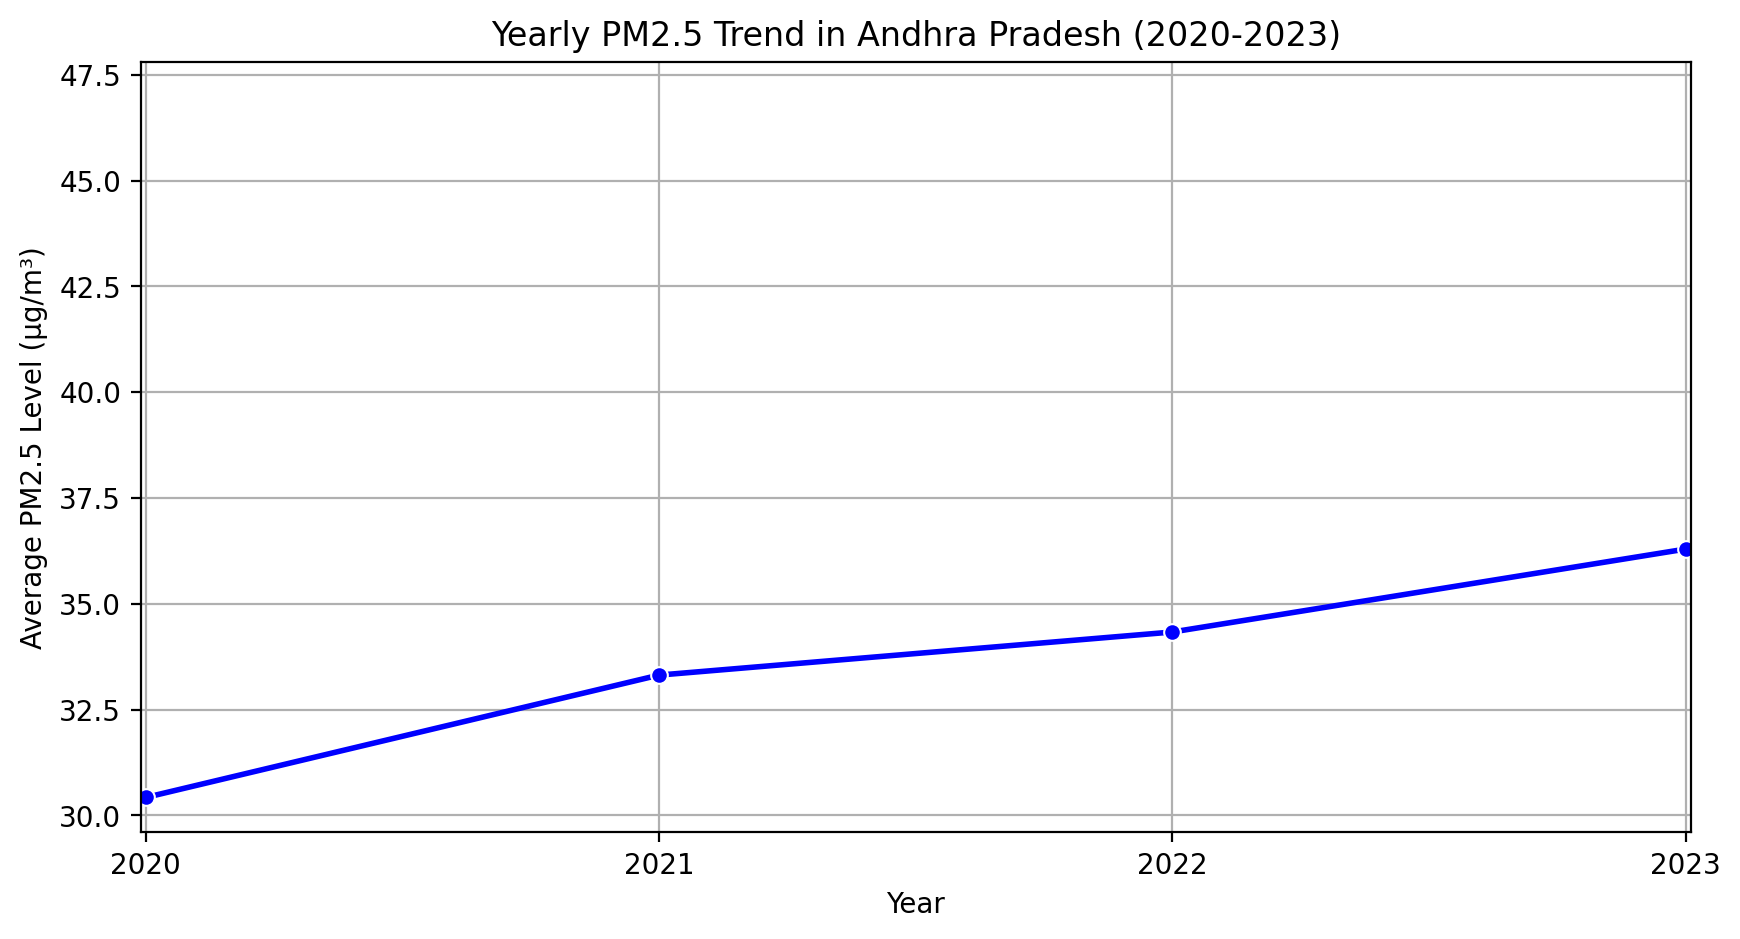

In [ ]:
highest_funding_state = funding_data.groupby('State')['Amount released during FY 2020-21'].sum().idxmax()

print(f"State with highest NCAP funding in 2020: {highest_funding_state}")

data["Timestamp"] = pd.to_datetime(data["Timestamp"], errors="coerce")
data["Year"]=data["Timestamp"].dt.year
state_pm_trend = data[data['state'] == highest_funding_state].groupby('Year')['PM2.5'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x = state_pm_trend.index, y = state_pm_trend.values, marker = 'o', linewidth = 2, color = 'b')

plt.xlabel("Year")
plt.ylabel("Average PM2.5 Level (μg/m³)")
plt.xlim(2019.99,2023.01)
plt.xticks([2020,2021,2022,2023])
plt.title(f"Yearly PM2.5 Trend in {highest_funding_state} (2020-2023)")
plt.grid(True)

plt.show()

4) Draw the map of India and plot the sensor locations on the map.


Sensor Distribution by State:
Maharashtra: 97 stations
Uttar Pradesh: 57 stations
Rajasthan: 46 stations
Karnataka: 42 stations
Delhi: 40 stations
Bihar: 36 stations
Tamil Nadu: 36 stations
Haryana: 32 stations
Madhya Pradesh: 29 stations
West Bengal: 22 stations
Odisha: 19 stations
Gujarat: 17 stations
Telangana: 14 stations
Chhattisgarh: 14 stations
Andhra Pradesh: 13 stations
Assam: 9 stations
Kerala: 9 stations
Punjab: 8 stations
Jharkhand: 4 stations
Chandigarh: 3 stations
Uttarakhand: 3 stations
Tripura: 2 stations
Meghalaya: 2 stations
Manipur: 2 stations
Puducherry: 1 stations
Himachal Pradesh: 1 stations
Arunachal Pradesh: 1 stations
Nagaland: 1 stations
Jammu and Kashmir: 1 stations
Mizoram: 1 stations
Sikkim: 1 stations


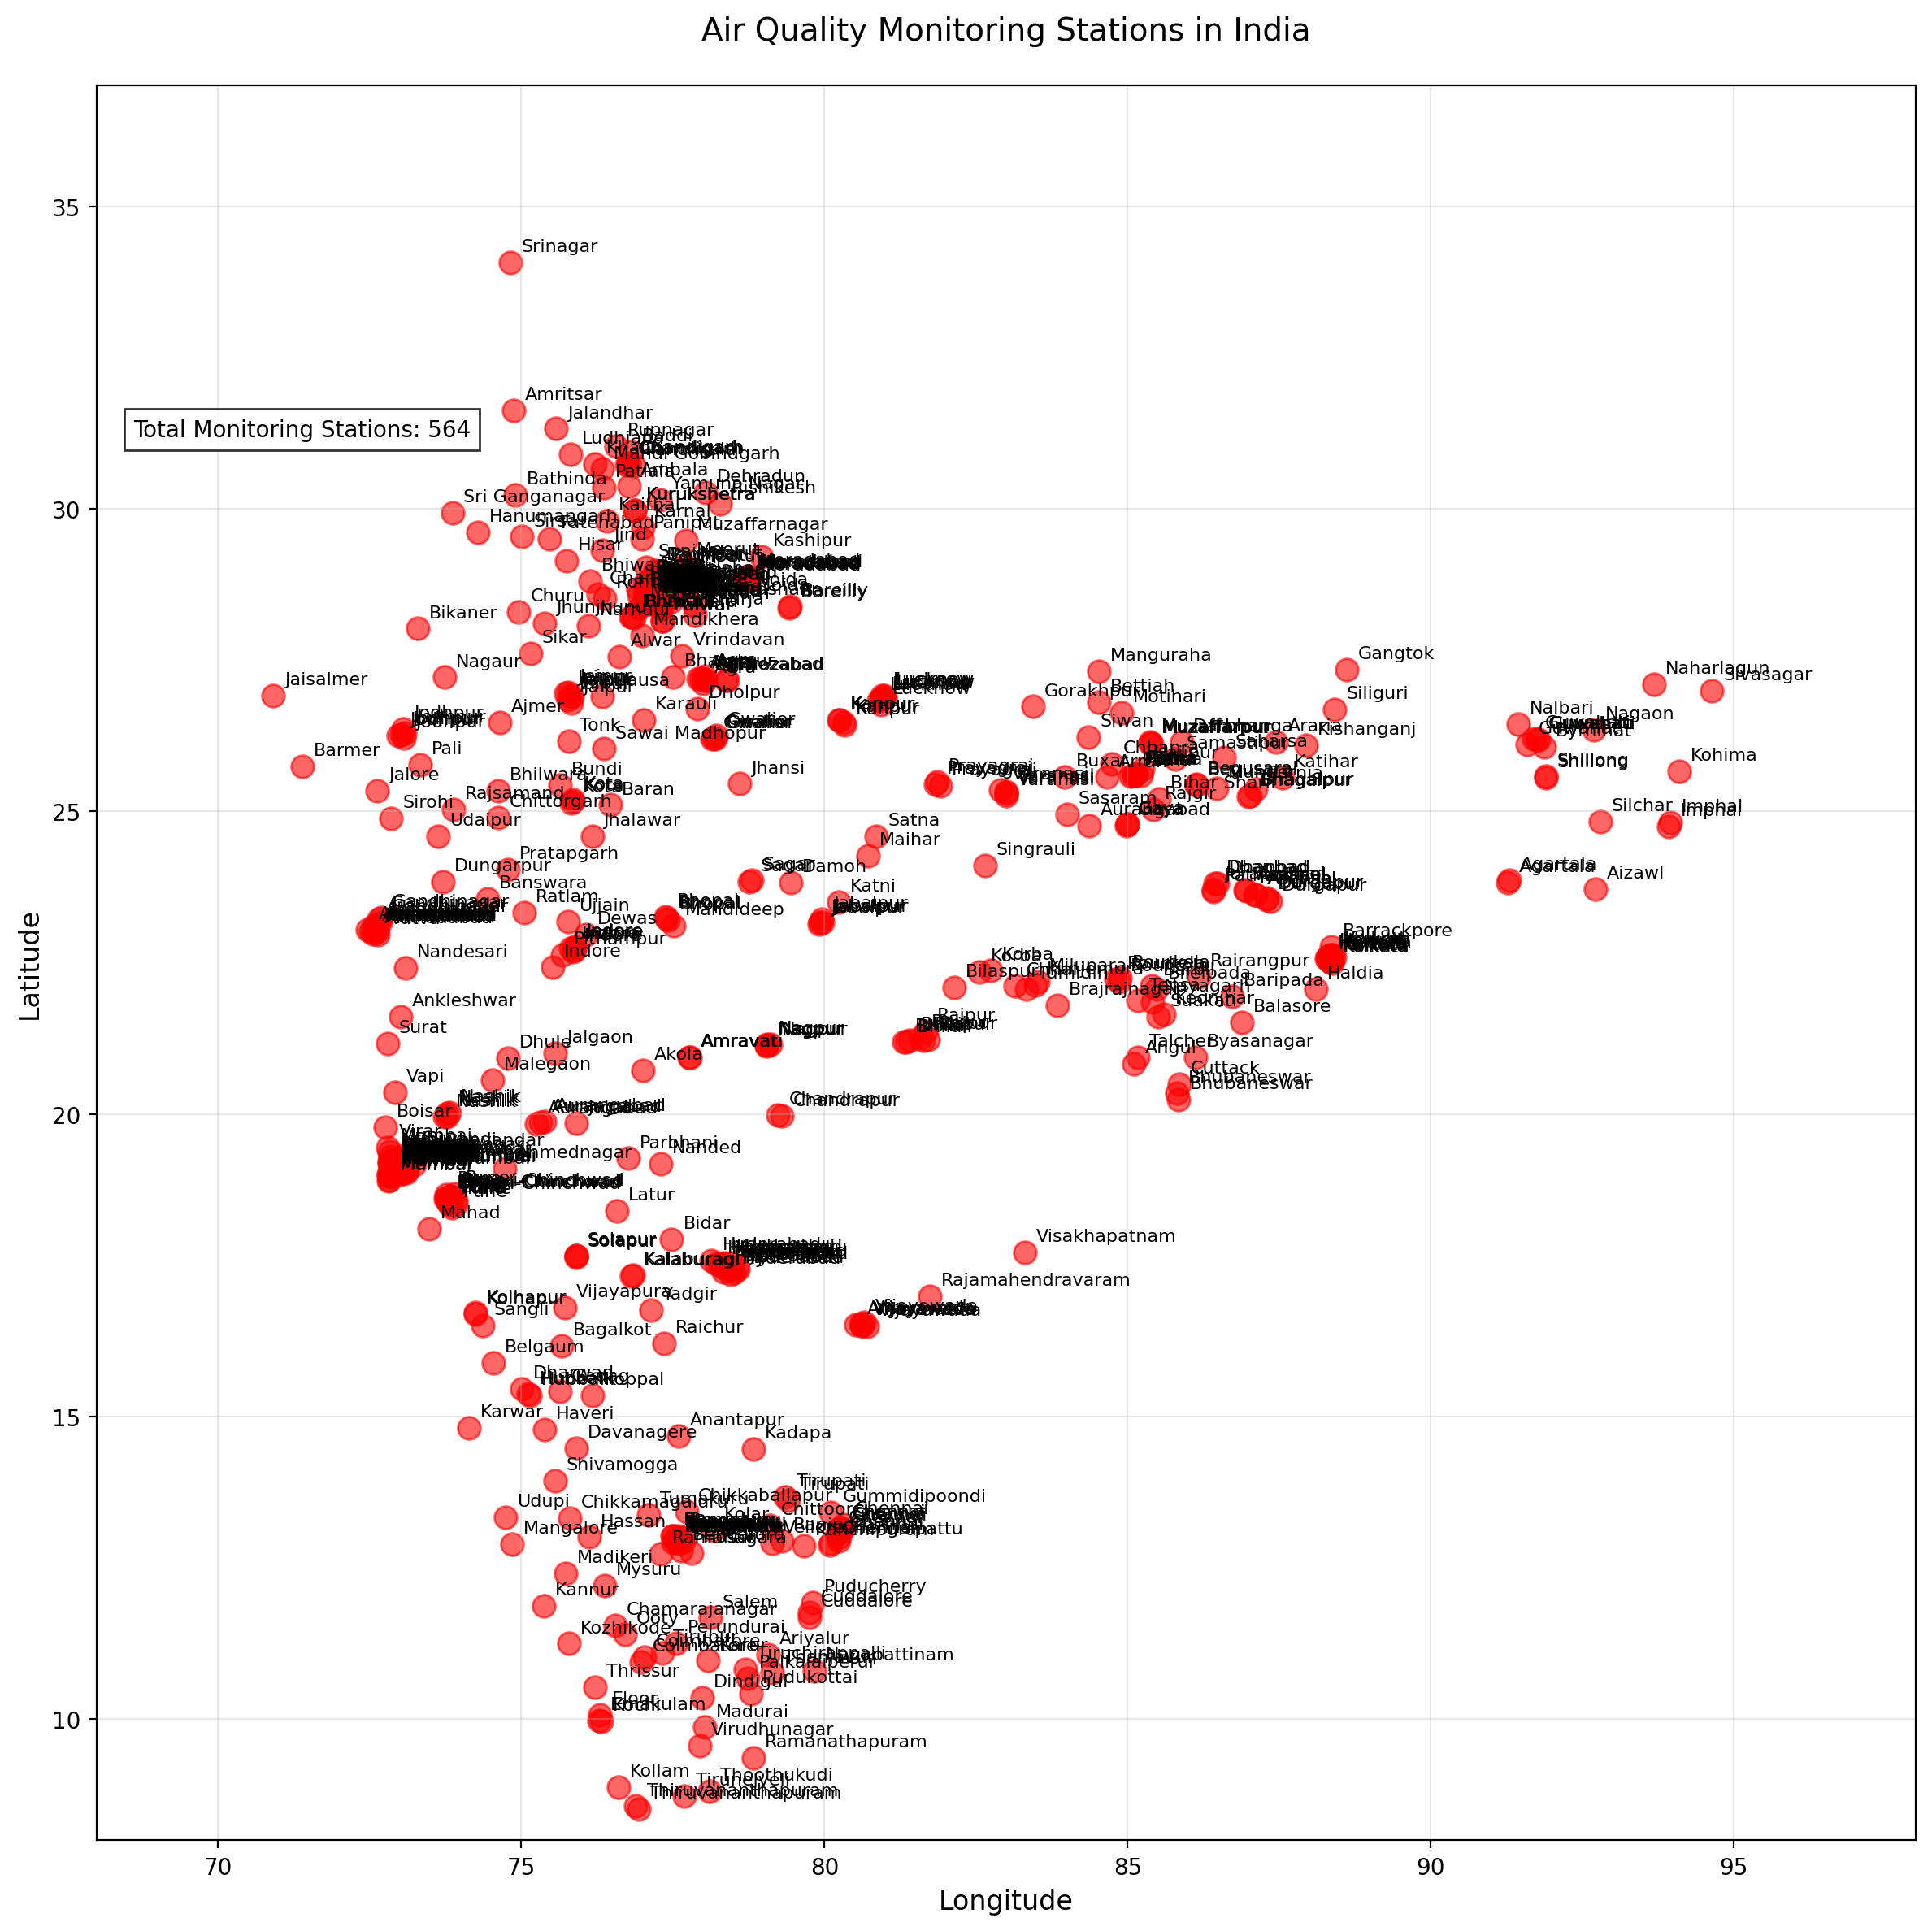

In [83]:
# import geopandas as gpd

# # Download India shapefile (you may need to adjust the URL based on the latest version)
# url = "https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_IND_shp.zip"
# india = gpd.read_file(url)

# # Create a sample dataset for states
# data = pd.DataFrame({
#     'State': india['NAME_1'],
#     'Value': np.random.randint(1, 100, len(india))
# })

# # Merge the data with the shapefile
# india = india.merge(data, left_on='NAME_1', right_on='State')

# # Create the plot
# fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# # Plot the map
# india.plot(column='Value', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', ax=ax, legend=True)

# # Customize the plot
# ax.axis('off')
# ax.set_title('India Map', fontsize=16)

# plt.tight_layout()
# plt.show()



# Create figure and axis with larger size
plt.figure(figsize=(12, 12))

# Get unique sensor locations to avoid duplicates
unique_locations = data[['latitude', 'longitude', 'city', 'state']].drop_duplicates()

# Create scatter plot
plt.scatter(unique_locations['longitude'],
           unique_locations['latitude'],
           c='red',
           alpha=0.6,
           s=100)

# Add labels for major cities
for idx, row in unique_locations.iterrows():
    plt.annotate(row['city'],
                (row['longitude'], row['latitude']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8)

# Customize the plot
plt.title('Air Quality Monitoring Stations in India', pad=20, fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Set map bounds to focus on India
plt.xlim(68, 98)
plt.ylim(8, 37)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Add text showing total number of stations
plt.text(0.02, 0.8,
         f'Total Monitoring Stations: {len(unique_locations)}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

# Print statistics
print("\nSensor Distribution by State:")
state_counts = unique_locations['state'].value_counts()
for state, count in state_counts.items():
    print(f"{state}: {count} stations")

plt.tight_layout()
plt.show()

# Tell us something new

Q) Tell us something interesting from the dataset that we have not asked. Anything that intrigues you, anything that might be useful to the policymakers.

Mismatch Between Pollution Levels and NCAP Funding

Some cities have high PM2.5 levels (top 25%) but received low funding (bottom 25%), suggesting they may have been overlooked in NCAP allocations.
Conversely, some cities received high funding but still have low improvement in air quality, indicating either inefficient fund utilization or external pollution sources.
Examples from the Data
High Pollution, Low Funding:

Angul (Odisha): PM2.5 = 118.56 µg/m³, NCAP funding = ₹1.2 crore
Nalbari (Assam): PM2.5 = 104.00 µg/m³, NCAP funding = ₹1.06 crore
Rourkela (Odisha): PM2.5 = 93.19 µg/m³, NCAP funding = ₹1.2 crore
These cities have some of the highest pollution levels but received minimal NCAP funds, suggesting possible oversight.
High Funding, Limited Pollution Improvement:

Chandigarh: NCAP funding = ₹17.89 crore, PM2.5 = 32.89 - 44.36 µg/m³
Srinagar (J&K): NCAP funding = ₹12.95 crore, PM2.5 = 28.33 µg/m³
These cities received significant funding but already have relatively low PM2.5 levels, raising concerns about fund allocation efficiency.